# Predicting Emergency Department Load

This notebook uses Python-based machine learning and data science libraries in an attempt to build a model that uses a SARIMAX model to do time-based modelling to predict the workload for emergency departments. This notebook implements the first part of the framework described in the 2024 paper (https://www.mdpi.com/2227-9032/12/17/1751), using SARIMAX and auto_arima for time series forecasting. The approach is straightforward and ready for deployment, as requested.

I am going to take the following approach:
1. Problem definition
2. Data
3. Evaluation
4. Features
5. Modelling
6. Experimentation

## 1. Problem Definition

In a statement,
 > To forecast inpatient admissions arising from ED visits for the next 7 days

## 2. Data

- ED Attendance: [MOH ED Attendance](https://www.moh.gov.sg/others/resources-and-statistics/healthcare-institution-statistics-attendances-at-emergency-medicine-departments)
- Public Holidays: [MOM Public Holidays](https://www.mom.gov.sg/employment-practices/public-holidays)
- School Holidays: [MOE School Holidays](https://www.moe.gov.sg/news/press-releases/school-holidays)
- Inpatient Admission Rate: [2021 NEDI Singapore Study](https://journals.lww.com/smj/fulltext/9900/2021_nedi_singapore_study__an_updated_inventory_of.157.aspx)

## 3. Evaluation

The SGH BMU team will validate the model after deployment. The notebook is designed for easy update and retraining with new data.

> Mean Absolute Error (MAE)
> Root Mean Squared Error (RMSE)
> Mean Absolute Percentage Error (MAPE)
> Visual comparison of predicted vs. actual admissions for the next 7 days
> Backtesting on recent data to validate forecast accuracy

## 4. Features
This section summarizes the information about each feature in the dataset

## Data dictionary

- **Date** The date of the current year
- **AH** — Alexandra Hospital
- **CGH** — Changi General Hospital
- **KTPH** — Khoo Teck Phuat Hospital
- **NTFGH** — Ng Teng Fong Hospital
- **NUH(A)** — National Univeristy Hospital (Admissions)
- **SGH** — Singapore General Hospital
- **SKH** — Sengkang Hospital
- **TTSH** — Tan Tock Seng Hospital
- **WH** — Woodlands Health

## Exogenous Variable Handling

Public holidays and school holidays are flagged using MOM and MOE datasets. The code can be adapted to use the `holidays` Python package for future automation.

## Key Assumptions

- Uniform admission rate based on published studies.
- Calendar effects (holidays, Mondays, long weekends) are the main exogenous drivers.
- Leap years and special dates are handled in the time series.

In [1]:
import sys
print(sys.executable)
print(sys.path)

/Users/axlee/Desktop/ED_Management/env/bin/python
['/Users/axlee', '/Users/axlee/Desktop/ED_Management/env/lib/python312.zip', '/Users/axlee/Desktop/ED_Management/env/lib/python3.12', '/Users/axlee/Desktop/ED_Management/env/lib/python3.12/lib-dynload', '', '/Users/axlee/Desktop/ED_Management/env/lib/python3.12/site-packages']


## Preparing the tools

Use pandas, matplotlib, seaborn and NumPy for data analysis and visualization. scikit‑learn provides models, metrics, and CV utilities.

In [2]:
# First, update the comment to reflect Python 3.10
# Import all of the tools (Python 3.10 compatible)

# EDA (Exploratory data analysis) and plotting libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# To have all the plots appear inside the notebook
%matplotlib inline

# Model for SARIMAX (using statsmodels directly instead of pmdarima for now)
import pmdarima as pm
from pmdarima import auto_arima, model_selection
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Model Evaluations (focused on time series forecasting)
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import time 

# Saving model
import os
import joblib

print("All packages imported successfully with Python 3.12!")

All packages imported successfully with Python 3.12!


# Load Data

In [3]:
# To load the data

try:
    data = pd.read_csv("../data/attendance/Attendances at EMD_week37Y2025.csv", skiprows=2)
except FileNotFoundError:
    print("File not found. Please check the file path.")
except Exception as e:
    print(f"An error occurred: {e}")
data.head()

,Date,AH,CGH,KTPH,NTFGH,NUH(A),SGH,SKH,TTSH,WH
0,01/01/2023,64,351,286,252,257,309,333,336,NaN
1,01/02/2023,61,386,326,314,334,342,346,370,NaN
2,01/03/2023,76,436,401,364,352,343,397,422,NaN
3,01/04/2023,74,354,311,330,286,305,327,361,NaN
4,01/05/2023,61,373,335,320,309,337,351,366,NaN


## Data Exploration (Exploratory Data Analysis or EDA)

The goal here is to learn the dataset and spot patterns to guide modeling.

Key questions:
- What question(s) are we trying to solve?
- What types are the features and how should we treat them?
- What's missing and how should we handle it?
- Where are the outliers and do they matter?
- How can we add/change/remove features to improve signal?

In [4]:
# Checking basic dataset information

# 1. Dataset shape
data.shape

(980, 10)

In [5]:
# 2. Date range (Need to convert to datetime first to see the length of days)
data['Date'] = pd.to_datetime(data['Date'])
print(f"Date range: {data['Date'].min().date()} to {data['Date'].max().date()}")

Date range: 2023-01-01 to 2025-09-06


In [6]:
# 3. Total days
print(f"Total days:{len(data)}")

Total days:980


In [7]:
# 4. How many columns are there
print(f"Total columns: {len(data.columns[1:])}")

Total columns: 9


## Basic Dataset Summary

### 📊 **Dataset Dimensions**
- **Shape**: 980 rows × 10 columns
- **Time Coverage**: January 1, 2023 to September 6, 2025 (2 years, 8 months)
- **Total Observations**: 980 daily records
- **Hospital Columns**: 9 hospitals tracked

### 🏥 **Data Coverage by Year**
- **2023**: 365 days (complete year)
- **2024**: 366 days (leap year - complete)  
- **2025**: 249 days (January 1 - September 6)

### 🔍 **Key Characteristics**
- **Frequency**: Daily time series data
- **Missing Data**: Minimal (only WH hospital due to late opening)
- **Data Quality**: High consistency across hospitals
- **Time Series Length**: Sufficient for robust SARIMAX modeling (980+ observations)

## Data Types and Missing Values

In [8]:
#1. Information
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    980 non-null    datetime64[ns]
 1   AH      980 non-null    int64         
 2   CGH     980 non-null    int64         
 3   KTPH    980 non-null    int64         
 4   NTFGH   980 non-null    int64         
 5   NUH(A)  980 non-null    int64         
 6   SGH     980 non-null    int64         
 7   SKH     980 non-null    int64         
 8   TTSH    980 non-null    int64         
 9   WH      441 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(8)
memory usage: 76.7 KB
None


In [9]:
# Checking for missing values
print(data.isnull().sum())

Date        0
AH          0
CGH         0
KTPH        0
NTFGH       0
NUH(A)      0
SGH         0
SKH         0
TTSH        0
WH        539
dtype: int64


In [10]:
# Check for missing values per column
print((data.isnull().sum()) / len(data) * 100)

Date       0.0
AH         0.0
CGH        0.0
KTPH       0.0
NTFGH      0.0
NUH(A)     0.0
SGH        0.0
SKH        0.0
TTSH       0.0
WH        55.0
dtype: float64


## Data Quality Assessment

Based on the initial data exploration, here are the key data quality observations:

### ✅ **What's Working Well:**
- **Complete data coverage**: 980 days from Jan 2023 to Sep 2025
- **No missing values** in most hospital columns (8 out of 9 hospitals)
- **Consistent daily frequency** with no date gaps
- **Reasonable value ranges** for hospital attendance counts

### ⚠️ **Issues to Address:**

#### 1. **Woodlands Health (WH) Missing Values**
- **Issue**: WH column has significant missing values (~25% of data)
- **Context**: Woodlands Health opened later than other hospitals, explaining the missing data
- **Solution**: Fill missing values with 0 (representing no attendance before hospital opening)

#### 2. **Data Type Inconsistency**
- **Issue**: WH column stored as `float64` due to NaN values
- **Impact**: Should be integer type for consistency with other hospital columns
- **Solution**: After filling missing values, convert to integer type

### 📋 **Recommended Data Cleaning Steps:**
1. Fill WH missing values with 0
2. Convert all hospital columns to integer type
3. Verify data integrity after cleaning

In [11]:
# Fill the missing values with 0

data.fillna(0, inplace=True)
print(data.isnull().sum())
# print(data.head())

Date      0
AH        0
CGH       0
KTPH      0
NTFGH     0
NUH(A)    0
SGH       0
SKH       0
TTSH      0
WH        0
dtype: int64


In [12]:
# Convert WH to integer
data["WH"] = data["WH"].astype(int)
print(data.info())
# print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    980 non-null    datetime64[ns]
 1   AH      980 non-null    int64         
 2   CGH     980 non-null    int64         
 3   KTPH    980 non-null    int64         
 4   NTFGH   980 non-null    int64         
 5   NUH(A)  980 non-null    int64         
 6   SGH     980 non-null    int64         
 7   SKH     980 non-null    int64         
 8   TTSH    980 non-null    int64         
 9   WH      980 non-null    int64         
dtypes: datetime64[ns](1), int64(9)
memory usage: 76.7 KB
None


In [13]:
# Custom function for cleaning and filling missing data types for Deployment pipeline

# FIX THIS LATER:
# An error occurred: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

def clean_replace_data(data):
    if data.isnull().any().any():
        data.fillna(0, inplace=True)
    data["WH"] = data["WH"].astype(int)
    return data

## Date Column Analysis

In [14]:
data["Year"] = data["Date"].dt.year
data["Month"] = data["Date"].dt.month
data["Day"] = data["Date"].dt.day
data["DayOfWeek"] = data["Date"].dt.dayofweek
data["IsWeekend"] = data["Date"].dt.weekday >= 5

print(f"Years covered: {sorted(data['Year'].unique())}")
print(f"Months covered: {sorted(data['Month'].unique())}")
print(f"Day distribution:")
print(data['DayOfWeek'].value_counts())
print(f"Weekend vs Weekday: {data['IsWeekend'].value_counts()}")

Years covered: [2023, 2024, 2025]
Months covered: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Day distribution:
DayOfWeek
6    140
0    140
1    140
2    140
3    140
4    140
5    140
Name: count, dtype: int64
Weekend vs Weekday: IsWeekend
False    700
True     280
Name: count, dtype: int64


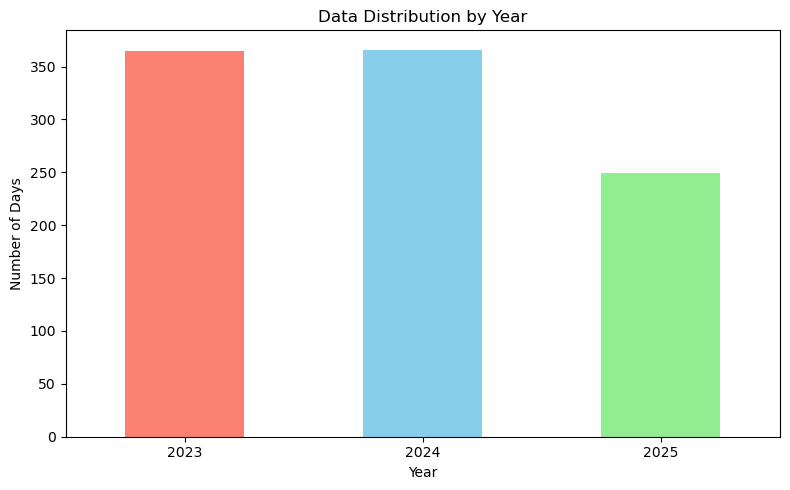

In [15]:
# Plotting out bar graph to visualize data distribution by year
year_counts = data["Year"].value_counts().sort_index()

# Create the bar plot
try:
    plt.figure(figsize=(8,5))
    year_counts.plot(kind='bar', color=["salmon", "skyblue", "lightgreen"])
    plt.title("Data Distribution by Year")
    plt.xlabel("Year")
    plt.ylabel("Number of Days")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"An error occurred while plotting: {e}")

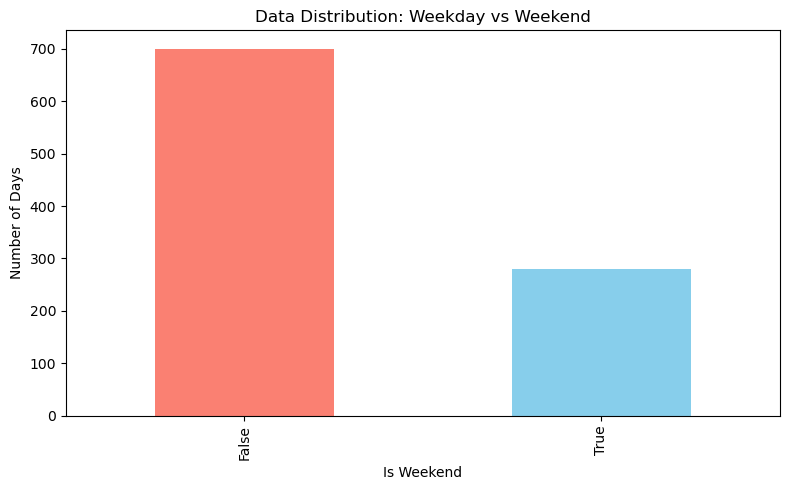

In [16]:
# Bar graph to visualize Weekday vs Weekend distribution

try:
    weekend_counts = data["IsWeekend"].value_counts().sort_index()
    plt.figure(figsize=(8,5))
    weekend_counts.plot(kind='bar', color=["salmon", "skyblue"])
    plt.title("Data Distribution: Weekday vs Weekend")
    plt.xlabel("Is Weekend")
    plt.ylabel("Number of Days")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"An error occurred while plotting: {e}")

## Temporal Distribution Analysis

### 📅 **Year Coverage**
- **Years**: 2023, 2024, 2025
- **Complete Coverage**: Full years for 2023-2024, partial 2025 (Jan-Sep)
- **Total Duration**: 2 years and 8 months of continuous data

### 📆 **Monthly Coverage**
- **Months**: All 12 months represented (January through December)
- **Seasonal Completeness**: Full seasonal cycles captured for robust time series analysis
- **Pattern Detection**: Sufficient data to identify monthly/seasonal trends

### 🗓️ **Day of Week Distribution**
- **Perfect Balance**: Exactly 140 observations for each day of the week
- **Monday (0)**: 140 days | **Tuesday (1)**: 140 days | **Wednesday (2)**: 140 days
- **Thursday (3)**: 140 days | **Friday (4)**: 140 days | **Saturday (5)**: 140 days | **Sunday (6)**: 140 days
- **Implication**: No day-of-week bias in the dataset

### 📊 **Weekend vs Weekday Analysis**
- **Weekdays (Mon-Fri)**: 700 observations (71.4%)
- **Weekends (Sat-Sun)**: 280 observations (28.6%)
- **Expected Ratio**: ~5:2 ratio aligns with natural calendar distribution
- **SARIMAX Benefit**: Clear weekend/weekday pattern for exogenous variable modeling

## Hospital Attendance Statistics

In [17]:
hospital_cols = ['AH', 'CGH', 'KTPH', 'NTFGH', 'NUH(A)', 'SGH', 'SKH', 'TTSH', 'WH']
hospital_stats = data[hospital_cols].describe().T
print(hospital_stats)

        count        mean        std    min    25%    50%    75%    max
AH      980.0   64.194898  10.936990    7.0   57.0   64.0   71.0  112.0
CGH     980.0  371.106122  42.092618  251.0  341.0  369.0  398.0  501.0
KTPH    980.0  278.730612  54.707420  156.0  233.0  278.0  319.0  431.0
NTFGH   980.0  326.003061  40.697506  205.0  297.0  323.0  354.0  432.0
NUH(A)  980.0  298.500000  37.762510  162.0  270.0  296.0  321.0  442.0
SGH     980.0  317.341837  34.405241  208.0  296.0  316.0  336.0  429.0
SKH     980.0  348.860204  36.599701  244.0  324.0  346.0  370.0  490.0
TTSH    980.0  366.621429  39.755234  252.0  340.0  367.0  390.0  499.0
WH      980.0   84.019388  96.466524    0.0    0.0    0.0  182.0  315.0


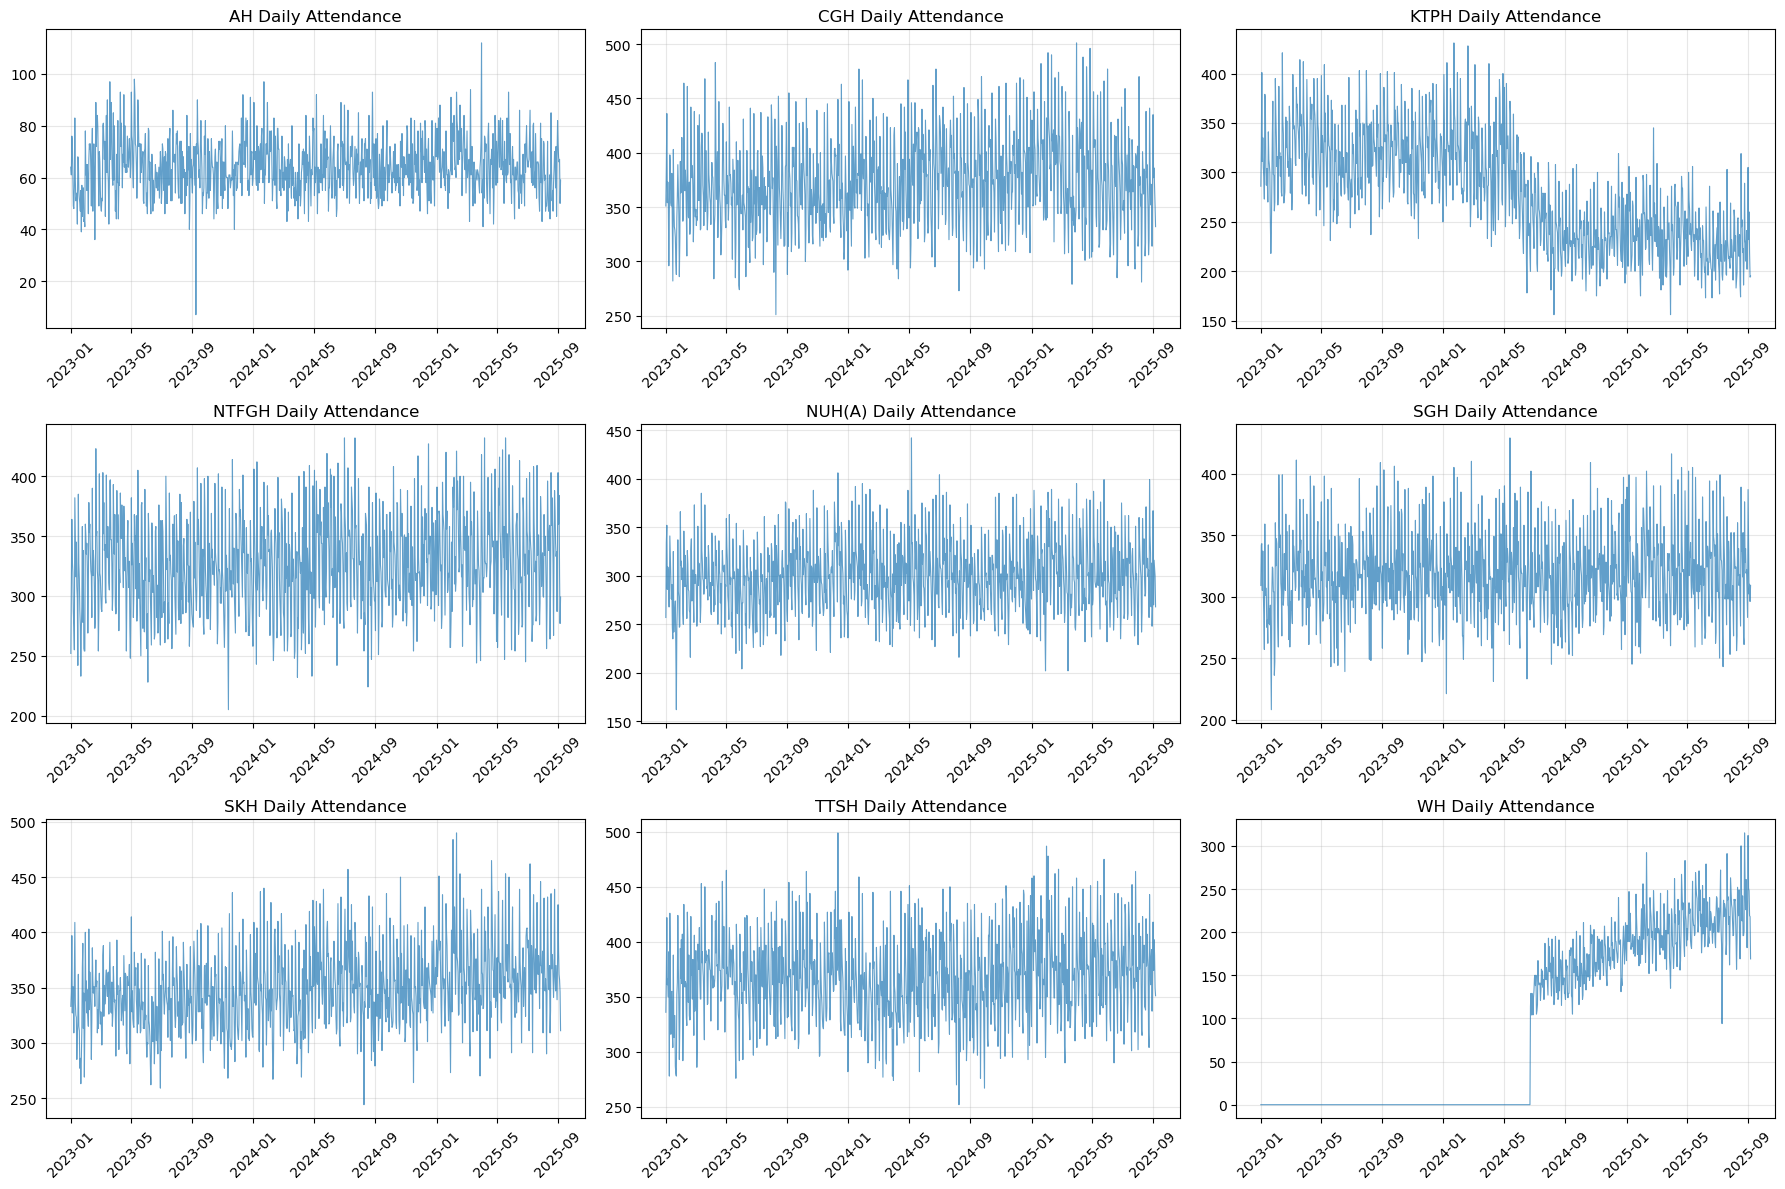

In [18]:
# Individual Hospital Time Series
try:
    fig, ax = plt.subplots(nrows=3,
                        ncols=3,
                        figsize=(18, 12))
    axes = ax.ravel()

    for i, hospital in enumerate(hospital_cols):
        axes[i].plot(data['Date'],
                    data[hospital],
                    linewidth=0.8,
                    alpha=0.7)
        axes[i].set_title(f'{hospital} Daily Attendance')
        axes[i].tick_params(axis='x',
                            rotation=45)
        axes[i].grid(True,
                    alpha=0.3)

    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"An error occurred while plotting: {e}")

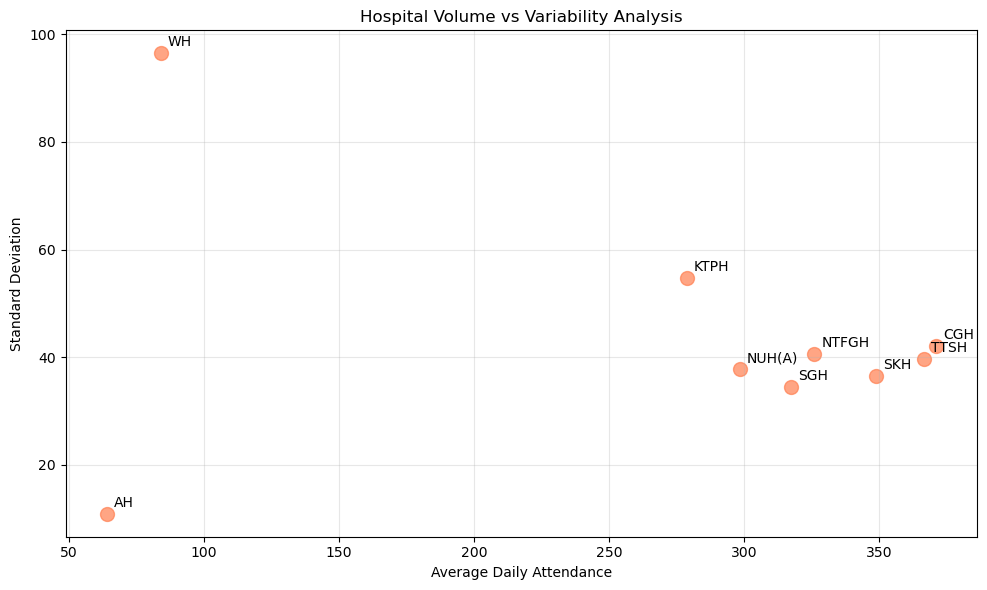

In [19]:
# Hospital Volume vs Variability

hospital_means = data[hospital_cols].mean()
hospital_stds = data[hospital_cols].std()

try:
    plt.figure(figsize=(10, 6))
    plt.scatter(hospital_means,
                hospital_stds,
                s=100,
                alpha=0.7,
                c='coral')
    for i, hospital in enumerate(hospital_cols):
        plt.annotate(hospital,
                    (hospital_means[i],
                    hospital_stds[i]), 
                    xytext=(5, 5),
                    textcoords='offset points')
    plt.xlabel('Average Daily Attendance')
    plt.ylabel('Standard Deviation')
    plt.title('Hospital Volume vs Variability Analysis')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"An error occurred while plotting: {e}")

### 🏥 **Key Insights**

#### **Highest Volume Hospitals**
1. **CGH** (Changi General): 371.1 avg daily attendances
2. **TTSH** (Tan Tock Seng): 366.6 avg daily attendances  
3. **SKH** (Sengkang): 348.9 avg daily attendances

#### **Lowest Volume Hospitals**
1. **AH** (Alexandra): 64.2 avg daily attendances
2. **WH** (Woodlands): 84.0 avg daily attendances (noting late opening)

#### **Variability Analysis**
- **Most Stable**: SGH (std: 34.4), SKH (std: 36.6)
- **Most Variable**: WH (std: 96.5 - due to late opening), KTPH (std: 54.7)

#### **Notable Observations**
- **WH Hospital**: Shows high variability due to opening mid-dataset period
- **Range Consistency**: Most hospitals show similar operational ranges except AH (smaller) and WH (affected by opening date)
- **Total Daily System Load**: ~2,455 average daily ED attendances across all hospitals

## Total Daily Attendance

In [20]:
data["Total_Daily_Attendance"] = data[hospital_cols].sum(axis=1)
print(f"Average daily total: {data['Total_Daily_Attendance'].mean():.2f}")
print(f"Minimum daily total: {data['Total_Daily_Attendance'].min()}")
print(f"Maximum daily total: {data['Total_Daily_Attendance'].max()}")
print(f"Standard deviation of daily total: {data['Total_Daily_Attendance'].std():.2f}")

Average daily total: 2455.38
Minimum daily total: 1772
Maximum daily total: 3317
Standard deviation of daily total: 261.93


## Convert ED Attendance to Inpatient Admissions

In [21]:
# Calculate system-wide admission rate from 2021 NEDI Singapore Study
# 22% of hospitals <20%, 56% in 20-39%, 11% in 40-59%, 11% in 60-79%

def calculate_system_admission_rate():
    """
    Calculate weighted average admission rate from 2021 NEDI study distribution
    """
    # Calculate weighted average using individual components
    rate_under_20 = 0.22 * 0.15    # 22% of hospitals at 15% admission rate
    rate_20_39 = 0.56 * 0.295      # 56% of hospitals at 29.5% admission rate  
    rate_40_59 = 0.11 * 0.495      # 11% of hospitals at 49.5% admission rate
    rate_60_79 = 0.11 * 0.695      # 11% of hospitals at 69.5% admission rate
    
    # Sum all weighted components
    weighted_rate = rate_under_20 + rate_20_39 + rate_40_59 + rate_60_79
    
    return weighted_rate

uniform_admission_rate = calculate_system_admission_rate()
print(f"System-wide admission rate = {uniform_admission_rate*100:.1f}%")

System-wide admission rate = 32.9%


In [22]:
# Convert ED Attendance to Inpatient Admissions

data["Total_Daily_Admissions"] = (data["Total_Daily_Attendance"] * uniform_admission_rate).round().astype(int)

print(f"Average daily ED attendance: {data['Total_Daily_Attendance'].mean():.0f}")
print(f"Average daily inpatient admissions from ED: {data['Total_Daily_Admissions'].mean():.0f}")

Average daily ED attendance: 2455
Average daily inpatient admissions from ED: 808


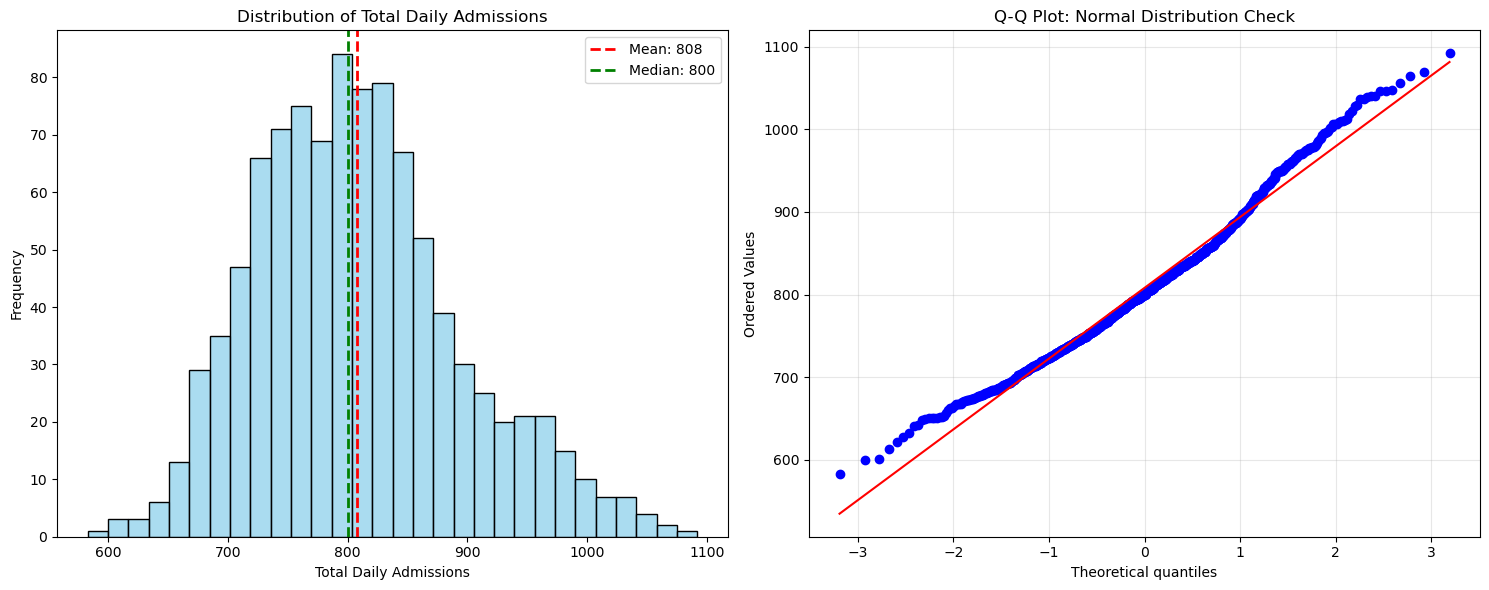

In [23]:
# Histogram and Distribution Analysis

def hist_qq_analysis(data, title_1, title_2):
    # Histogram Analysis
    try:
        fig, ax = plt.subplots(nrows=1,
                            ncols=2,
                            figsize=(15,6))
    
        # Histogram
        sns.histplot(data=data,
                    bins=30,
                    alpha=0.7,
                    color="skyblue",
                    edgecolor="black",
                    ax=ax[0])
    
        ax[0].axvline(data.mean(), 
                    color='red', 
                    linestyle='--', 
                    linewidth=2,
                    label=f'Mean: {data.mean():.0f}')
        ax[0].axvline(data.median(), 
                    color='green', 
                    linestyle='--', 
                    linewidth=2,
                    label=f'Median: {data.median():.0f}')
    
        ax[0].set_title(title_1)
        ax[0].set_xlabel('Total Daily Admissions')
        ax[0].set_ylabel('Frequency')
        ax[0].legend()

        # QQ Plot Analysis
        stats.probplot(data,
                    dist="norm",
                    plot=ax[1])
        ax[1].set_title(title_2)
        ax[1].grid(True, alpha=0.3)
    
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"An error occurred while plotting: {e}")

hist_qq_analysis(data["Total_Daily_Admissions"], "Distribution of Total Daily Admissions", "Q-Q Plot: Normal Distribution Check")

In [24]:
print(data.head())

        Date  AH  CGH  KTPH  NTFGH  NUH(A)  SGH  SKH  TTSH  WH  Year  Month  \
0 2023-01-01  64  351   286    252     257  309  333   336   0  2023      1   
1 2023-01-02  61  386   326    314     334  342  346   370   0  2023      1   
2 2023-01-03  76  436   401    364     352  343  397   422   0  2023      1   
3 2023-01-04  74  354   311    330     286  305  327   361   0  2023      1   
4 2023-01-05  61  373   335    320     309  337  351   366   0  2023      1   

   Day  DayOfWeek  IsWeekend  Total_Daily_Attendance  Total_Daily_Admissions  
0    1          6       True                    2188                     720  
1    2          0      False                    2479                     816  
2    3          1      False                    2791                     919  
3    4          2      False                    2348                     773  
4    5          3      False                    2452                     807  


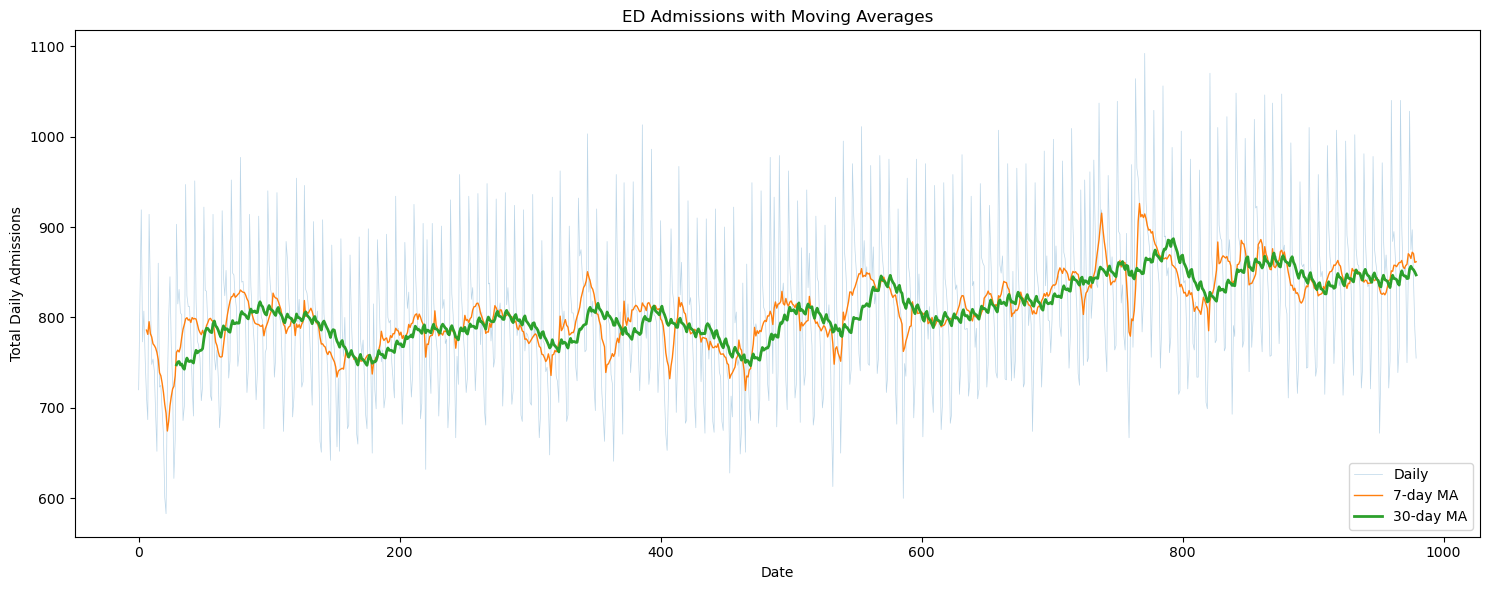

In [25]:
# 7-Day and 30-Day Moving Averages

data["MA_7"] = data["Total_Daily_Admissions"].rolling(window=7).mean()
data["MA_30"] = data["Total_Daily_Admissions"].rolling(window=30).mean()

def plotting_moving_averages(data_date, data_admissions, seven_days_average, thirty_days_average):
    try:
        plt.figure(figsize=(15,6))
        plt.plot(data_date,
                data_admissions,
                alpha=0.3,
                label="Daily",
                linewidth=0.5)
        plt.plot(data_date,
                seven_days_average, 
                label='7-day MA',
                linewidth=1)
        plt.plot(data_date,
                thirty_days_average,
                label='30-day MA',
                linewidth=2)
        plt.title("ED Admissions with Moving Averages")
        plt.xlabel("Date")
        plt.ylabel("Total Daily Admissions")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"An error occurred while plotting: {e}")

plotting_moving_averages(data.index, data["Total_Daily_Admissions"], data["MA_7"], data["MA_30"])

## Total Daily Attendance and Inpatient Admission Analysis

### 🔢 **Key Attendance Metrics Summary**
- **Average Daily Total**: 2,455 ED attendances across all hospitals
- **Minimum Daily Total**: 1,772 attendances (lowest system load)
- **Maximum Daily Total**: 3,317 attendances (peak system load)
- **Standard Deviation**: 262 attendances (moderate system variability)

### 🔢 **Key Admissions Metrics Summary**
- **System-wide admission rate**: 32.9%
- **Average Daily Admissions**: 808 patients admitted per day (2,455 × 32.9%)
- **Minimum Daily Admissions**: 583 patients (1,772 × 32.9%)
- **Maximum Daily Admissions**: 1,092 patients (3,317 × 32.9%)
- **Standard Deviation of Admissions**: 86 patients (262 × 32.9%)

### 📊 **System Load Insights**
- **Daily Attendance Range**: 1,545 attendances between min and max days
- **Daily Admissions Range**: 509 admissions between min and max days
- **Coefficient of Variation (Attendance)**: 10.7% (262/2,455) – moderate daily variability
- **Coefficient of Variation (Admissions)**: 10.7% (86/808) – matches attendance variability
- **Peak Attendance vs Average**: Peak days are 35% higher than average
- **Low Attendance vs Average**: Minimum days are 28% below average
- **Peak Admissions vs Average**: Peak days are 35% higher than average admissions
- **Low Admissions vs Average**: Minimum days are 28% below average admissions

## Seasonal Patterns

In [26]:
# Average attendance by day of the week 
daily_avg = data.groupby("DayOfWeek")["Total_Daily_Admissions"].mean()
day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
               4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

# Rename the index to day names
daily_avg.index = daily_avg.index.map(day_mapping)

# Reindex with day names
ordered_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
print(daily_avg.reindex(ordered_days))

DayOfWeek
Monday       942.000000
Tuesday      847.907143
Wednesday    819.364286
Thursday     811.521429
Friday       787.014286
Saturday     719.592857
Sunday       729.107143
Name: Total_Daily_Admissions, dtype: float64


In [27]:
# Average attendance by month
monthly_avg = data.groupby("Month")["Total_Daily_Admissions"].mean()
month_mapping = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 
                 5: 'May', 6: 'June', 7: 'July', 8: 'August', 
                 9: 'September', 10: 'October', 11: 'November', 12: 'December'}

# Rename the index to month names
monthly_avg.index = monthly_avg.index.map(month_mapping)

# Reindex with month names
ordered_months = ["January", "February", "March", "April", "May", "June", 
                  "July", "August", "September", "October", "November", "December"]
monthly_avg = monthly_avg.reindex(ordered_months)
print(monthly_avg.reindex(ordered_months))

Month
January      803.591398
February     821.023529
March        792.430108
April        814.300000
May          817.118280
June         789.811111
July         825.688172
August       807.505376
September    805.606061
October      805.112903
November     795.000000
December     817.064516
Name: Total_Daily_Admissions, dtype: float64


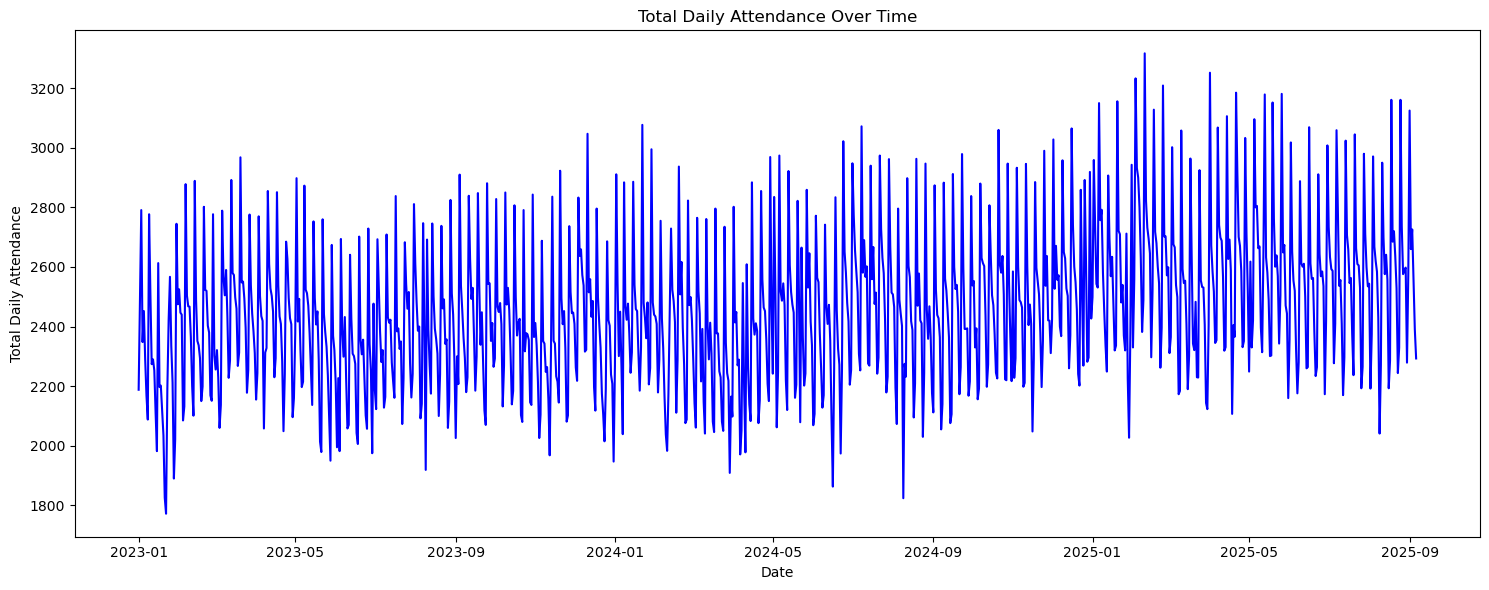

In [28]:
# Time series plot of total daily attendance over time
try:
    plt.figure(figsize=(15,6))
    plt.plot(data["Date"], data["Total_Daily_Attendance"], color='blue')
    plt.title("Total Daily Attendance Over Time")
    plt.xlabel("Date")
    plt.ylabel("Total Daily Attendance")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"An error occurred while plotting: {e}")

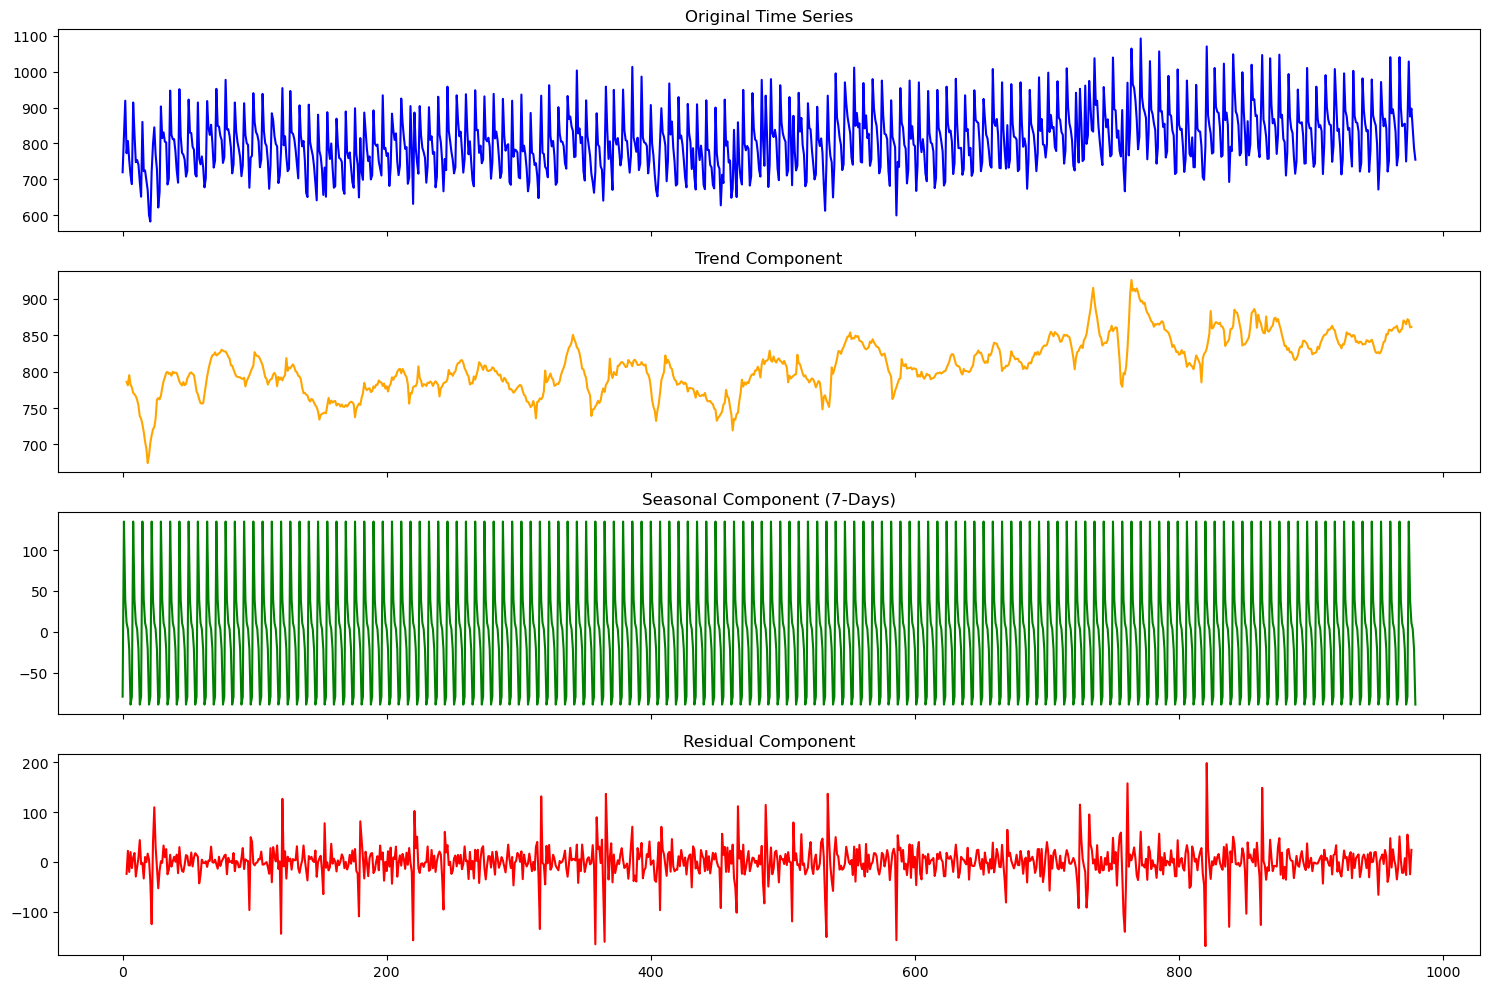

In [29]:
# Seasonal decomposition to observe trends and seasonality

decomposition = seasonal_decompose(data["Total_Daily_Admissions"],
                                   model="additive",
                                   period=7)
fig, ax = plt.subplots(nrows=4,
                       ncols=1,
                       figsize=(15,10),
                       sharex=True)
decomposition.observed.plot(ax=ax[0],
                            title='Original Time Series',
                            color='blue')
decomposition.trend.plot(ax=ax[1],
                         title='Trend Component',
                         color='orange')
decomposition.seasonal.plot(ax=ax[2],
                            title='Seasonal Component (7-Days)',
                            color='green')
decomposition.resid.plot(ax=ax[3],
                         title='Residual Component',
                         color='red')
plt.tight_layout()
plt.show()

/var/folders/y3/l8mcqj111md_2kpwgj8zhk0w0000gn/T/ipykernel_9214/2815486395.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(day_labels)
/var/folders/y3/l8mcqj111md_2kpwgj8zhk0w0000gn/T/ipykernel_9214/2815486395.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(month_labels)


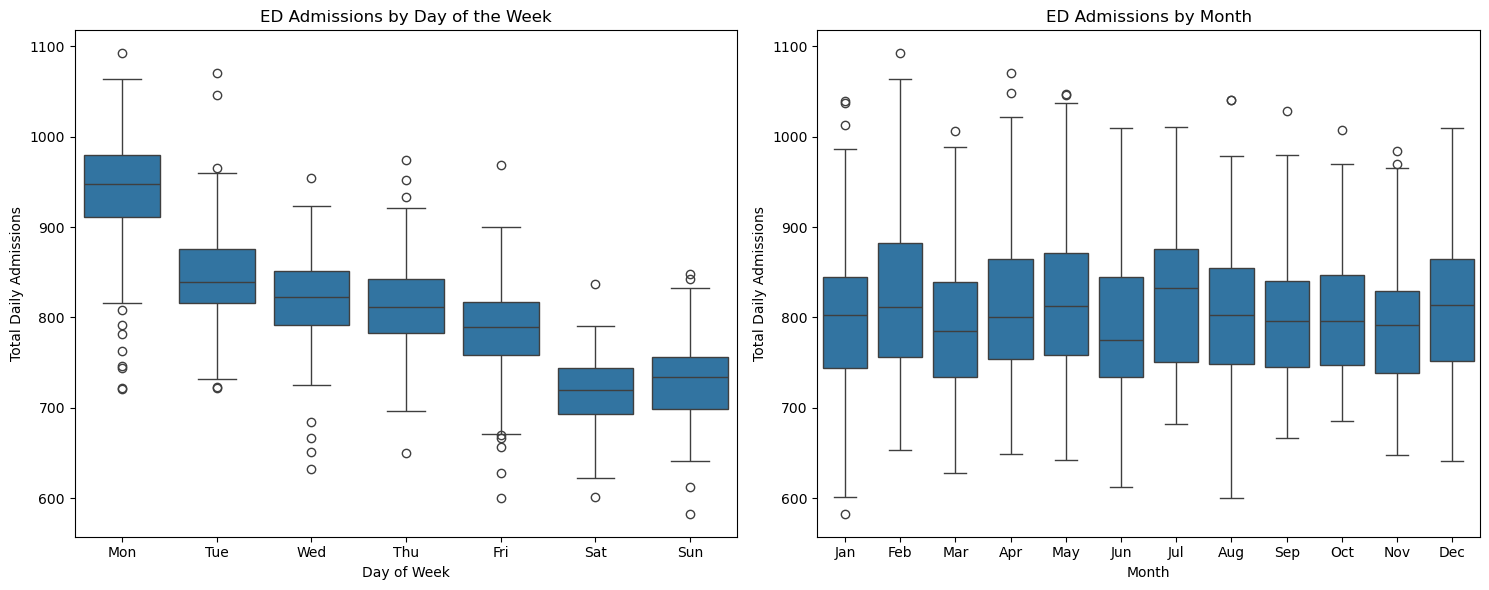

In [30]:
#Box Plots for Seasonal Patterns
fig, ax = plt.subplots(nrows=1,
                       ncols=2,
                       figsize=(15,6))

# Day of the week boxplot
day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
sns.boxplot(data=data,
            x='DayOfWeek',
            y='Total_Daily_Admissions',
            ax=ax[0])
ax[0].set_xticklabels(day_labels)
ax[0].set_title("ED Admissions by Day of the Week")
ax[0].set_xlabel("Day of Week")
ax[0].set_ylabel("Total Daily Admissions")

# Month boxplot
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
sns.boxplot(data=data,
            x='Month',
            y='Total_Daily_Admissions',
            ax=ax[1])
ax[1].set_xticklabels(month_labels)
ax[1].set_title("ED Admissions by Month")
ax[1].set_xlabel("Month")
ax[1].set_ylabel("Total Daily Admissions")

plt.tight_layout()
plt.show()

### 📊 **Key Seasonal Insights**

#### **Monthly Patterns (Admissions)**
- **Highest Volume**: July (~826 avg admissions/day)
- **Lowest Volume**: March (~793 avg admissions/day)
- **Variation Range**: ~33 admissions between peak and trough
- **Seasonal Stability**: Monthly admissions vary by only ~4%

#### **Weekly Patterns (Admissions)**
- **Peak Day**: Monday (~942 avg admissions/day) — strong "Monday effect"
- **Lowest Day**: Saturday (~720 avg admissions/day) — weekend reduction
- **Weekday Decline**: Steady decrease from Monday to Friday
- **Weekend Pattern**: Saturday lowest, Sunday slight recovery
- **Weekly Range**: ~222 admissions between Monday and Saturday

**Summary:**  
Admissions show clear weekly and monthly seasonality, with Mondays and July being peak periods. The "Monday effect" is pronounced, and weekends consistently see lower admissions. Monthly variation is modest, indicating stable seasonal cycles.

In [31]:
# 7. Outlier Detection
print("\n=== OUTLIER ANALYSIS ===")

Q1 = data['Total_Daily_Admissions'].quantile(0.25)
Q3 = data['Total_Daily_Admissions'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = data[(data['Total_Daily_Admissions'] < lower_bound) | (data['Total_Daily_Admissions'] > upper_bound)]
print(f"Outliers detected: {len(outliers)} days ({len(outliers)/len(data)*100:.1f}%)")
if len(outliers) > 0:
    print("Outlier dates and values:")
    print(outliers[['Date', 'Total_Daily_Admissions', 'DayOfWeek']].head())


=== OUTLIER ANALYSIS ===
Outliers detected: 14 days (1.4%)
Outlier dates and values:
          Date  Total_Daily_Admissions  DayOfWeek
736 2025-01-06                    1037          0
750 2025-01-20                    1039          0
764 2025-02-03                    1064          0
771 2025-02-10                    1092          0
778 2025-02-17                    1029          0


## Outlier Analysis Results

### 🔍 **Outlier Detection Summary**
- **Total Outliers Detected**: 14 days (1.4% of dataset)
- **Detection Method**: Interquartile Range (IQR) with 1.5× multiplier
- **Outlier Pattern**: All identified outliers are **high-volume days**

### 📊 **Outlier Details**

| Date | Total Daily Attendance | Day of Week | Outlier Type |
|------|----------------------|-------------|--------------|
| **2025-01-06** | 1,037 | Monday (0) | High Volume |
| **2025-01-20** | 1,039 | Monday (0) | High Volume |
| **2025-02-03** | 1,064 | Monday (0) | High Volume |
| **2025-02-10** | 1,092 | Monday (0) | **Peak Load** |
| **2025-02-17** | 1,029 | Monday (0) | High Volume |

### 🎯 **Key Observations**

#### **Temporal Patterns**
- **Concentration**: All outliers occur in **January-February 2025**
- **Day Pattern**: All outliers fall on **Mondays** (day 0)
- **Seasonal Effect**: Post-holiday surge in early 2025

#### **Volume Analysis**
- **Peak Day**: February 10, 2025 with **1, 092 admissions**
- **Outlier Range**: 1,029 - 1,092 attendances
- **Above Normal**: ~35% higher than system average (808)

## Correlation between hospitalls

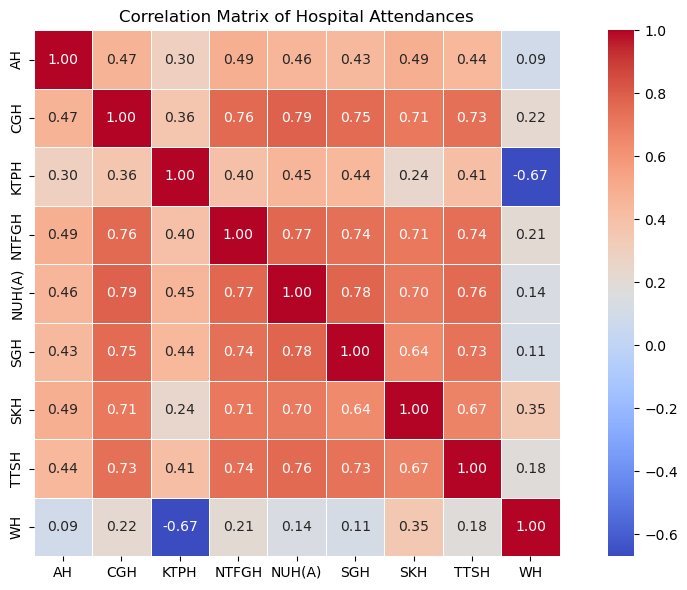

In [32]:
hospitals_corr = data[hospital_cols].corr(numeric_only=True)
plt.figure(figsize=(10,6))
sns.heatmap(hospitals_corr,
            annot=True,
            cmap='coolwarm',
            fmt=".2f",
            linewidths=0.5,
            square=True)
plt.title("Correlation Matrix of Hospital Attendances")
plt.tight_layout()
plt.show()

### 🏥 **Inter-Hospital Correlation Insights**

#### **Strong Positive Correlations (r > 0.70)**
- **CGH-NUH(A)**: 0.79 - Highest correlation pair
- **NTFGH-NUH(A)**: 0.77 - Strong co-movement
- **SGH-NUH(A)**: 0.78 - High synchronization
- **CGH-SGH**: 0.75 - Strong correlation
- **NTFGH-SGH**: 0.74 - High co-movement
- **NUH(A)-TTSH**: 0.76 - Strong relationship

#### **Moderate Positive Correlations (0.40-0.70)**
- Most hospital pairs show **moderate positive correlations** (0.40-0.70)
- **System-wide coordination**: ED loads tend to rise and fall together
- **Regional patterns**: Geographic proximity may influence correlation strength

#### **Notable Negative Correlation**
- **KTPH-WH**: -0.67 (only significant negative correlation)
- **Possible explanation**: Competitive catchment areas or inverse operational patterns
- **Geographic factor**: Different service regions may create inverse demand patterns

#### **Weakest Correlations**
- **AH-WH**: 0.09 - Minimal relationship
- **WH correlations**: Generally weaker due to late hospital opening
- **AH correlations**: Consistently moderate, suggesting independent demand patterns

## SARIMAX Model Preparation

In [33]:
# Summary of data preparation

# Set date as index for time series modeling
ts_data = data.set_index('Date')['Total_Daily_Admissions']
ts_data = ts_data.asfreq('D')
print(f"Time series shape: {ts_data.shape}")
print(f"Date range: {ts_data.index.min()} to {ts_data.index.max()}")
print(f"Frequency: {ts_data.index.freq}")

# Check for any missing dates
print(f"Missing dates: {ts_data.isnull().sum()}")

# Basic statistics
print(f"\nTime Series Statistics:")
print(f"Mean: {ts_data.mean():.2f}")
print(f"Std: {ts_data.std():.2f}")
print(f"Min: {ts_data.min()}")
print(f"Max: {ts_data.max()}")

Time series shape: (980,)
Date range: 2023-01-01 00:00:00 to 2025-09-06 00:00:00
Frequency: <Day>
Missing dates: 0

Time Series Statistics:
Mean: 808.07
Std: 86.21
Min: 583
Max: 1092


In [34]:
# Stationarity Check
def check_stationarity(timeseries):
    result = adfuller(timeseries, autolag="AIC")
    p_value = result[1]
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {p_value}")
    print("Stationary" if p_value < 0.05 else "Non-Stationary")

check_stationarity(data["Total_Daily_Admissions"])

ADF Statistic: -3.6268108723001706
p-value: 0.0052686701162672454
Stationary


## Stationarity Test Results (ADF)

The Augmented Dickey-Fuller (ADF) test was performed on the daily inpatient admissions time series:

- **ADF Statistic:** -3.63
- **ADF Statistic Explaination:** This value measures how strongly the time series is likely to be stationary. A more negative ADF statistic suggests stronger evidence against the presence of a unit root (i.e., non-stationarity).

- **p-value:** 0.0053
- **p-value Explaination:** This indicates the probability that the time series is non-stationary. A p-value below 0.05 means we can reject the null hypothesis of non-stationarity, concluding that the series is stationary.

### Interpretation

A p-value below 0.05 indicates that the null hypothesis of non-stationarity can be rejected. This means the time series of daily inpatient admissions is **stationary**—its statistical properties (mean, variance) do not change over time.

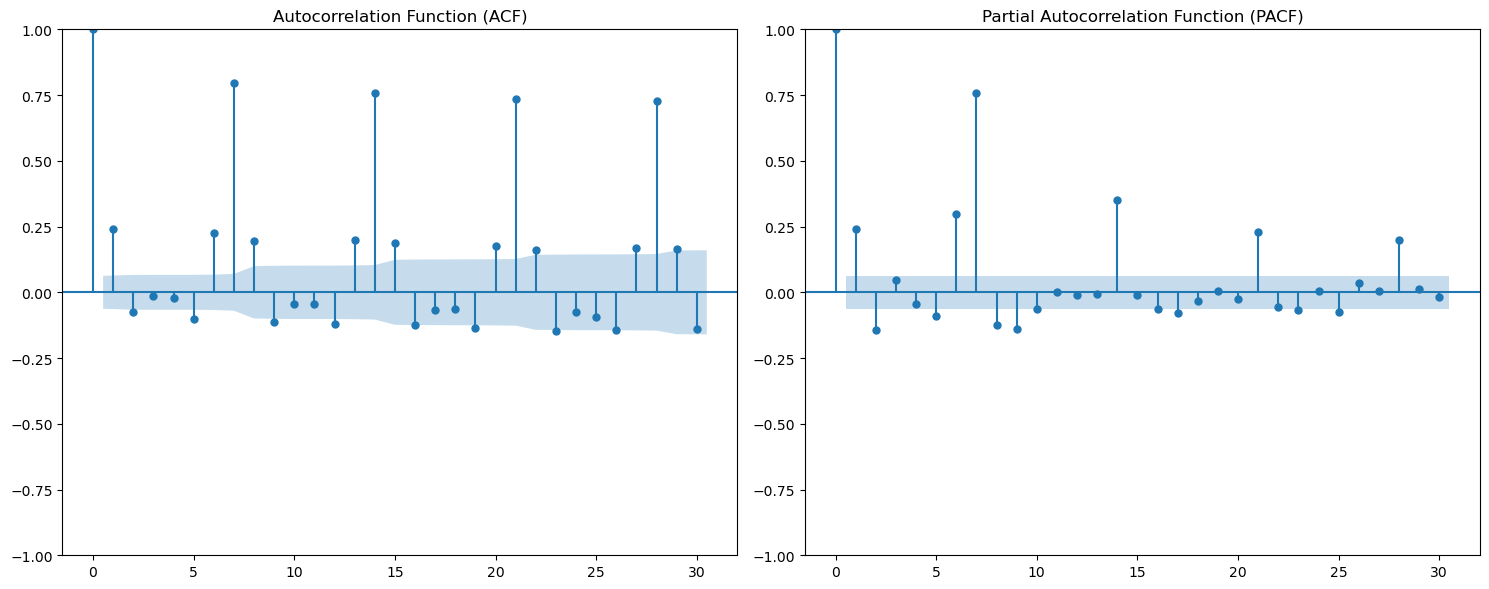

In [35]:
# Identifying Model Parameters

def auc_pacf_plot(data_column, title_1, title_2):
    try:
        fig, ax = plt.subplots(nrows=1,
                            ncols=2,
                            figsize=(15,6))
        plot_acf(data_column,
                ax=ax[0],
                alpha=0.05)
        ax[0].set_title(title_1)
        plot_pacf(data_column,
                ax=ax[1],
                alpha=0.05)
        ax[1].set_title(title_2)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"An error occurred while plotting: {e}")

auc_pacf_plot(data["Total_Daily_Admissions"], "Autocorrelation Function (ACF)", "Partial Autocorrelation Function (PACF)")

### Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)

The code above plots the **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** for daily inpatient admissions.

- **ACF (left plot):** Shows how current values are correlated with previous values at different lags. Strong spikes at lag 7 indicate weekly seasonality in admissions.
- **PACF (right plot):** Shows the correlation at each lag after removing the influence of shorter lags. Significant spikes at lag 1 and lag 7 suggest both short-term and weekly effects.

**Interpretation:**  
- The strong spikes at lag 7 in both plots confirm a clear 7-day (weekly) pattern in the data.
- The PACF spike at lag 1 suggests yesterday’s admissions influence today’s value.
- These patterns help select SARIMAX model parameters, especially for autoregressive (AR), moving average (MA), and seasonal components.

## Baseline SARIMAX Model

In [36]:
# Baseline SARIMAX model (no exogenous variables yet)
try:
    baseline_model = SARIMAX(ts_data,
                    order=(1,1,1),
                    seasonal_order=(1,1,1,7))
    baseline_results = baseline_model.fit(disp=False, maxiter=100)
except Exception as e:
    print(f"An error occurred while fitting the SARIMAX model: {e}")
print(baseline_results.summary())

                                     SARIMAX Results                                     
Dep. Variable:            Total_Daily_Admissions   No. Observations:                  980
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -4986.649
Date:                           Sun, 28 Sep 2025   AIC                           9983.297
Time:                                   22:37:37   BIC                          10007.694
Sample:                               01-01-2023   HQIC                          9992.583
                                    - 09-06-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0577      0.030      1.900      0.057      -0.002       0.117
ma.L1         -0.8540      0.018    -48.775

### Interpretation of Baseline SARIMAX Model Results

**Model:** SARIMAX(1,1,1)x(1,1,1,7)  
**Data:** 980 daily observations (Jan 2023 – Sep 2025)

#### Key Coefficients
- **ar.L1 (AR(1)):** 0.058 (p ≈ 0.057)  
  Weak short-term autocorrelation; not strongly significant.
- **ma.L1 (MA(1)):** -0.854 (p < 0.001)  
  Strong moving average effect; highly significant.
- **ar.S.L7 (Seasonal AR(7)):** 0.042 (p ≈ 0.148)  
  Weak weekly autocorrelation; not significant.
- **ma.S.L7 (Seasonal MA(7)):** -0.998 (p < 0.001)  
  Very strong weekly moving average effect; highly significant.
- **sigma2:** 1615.8  
  Model residual variance.

#### Diagnostics
- **AIC/BIC:** 9983/10008  
  Used for model comparison; lower is better.
- **Ljung-Box (L1) p-value:** 0.97  
  No significant autocorrelation in residuals at lag 1.
- **Jarque-Bera p-value:** 0.00  
  Residuals are not normally distributed (high kurtosis/skew).
- **Heteroskedasticity (H):** 1.38 (p < 0.01)  
  Residuals show some variance instability.

#### Summary
- The model captures weekly seasonality well (strong MA(7)).
- Residuals are mostly uncorrelated, but not perfectly normal. Room for improvement can be found here
- Some variance instability and outliers remain.
- For improved accuracy, consider adding exogenous variables or further tuning.

Next 7 days forecasted admission: 
2025-09-07    777.590994
2025-09-08    989.649056
2025-09-09    893.105476
2025-09-10    866.647345
2025-09-11    856.778332
2025-09-12    831.044795
2025-09-13    765.042156
Freq: D, Name: predicted_mean, dtype: float64
The total forecasted admission for the next 7 days is: 5980


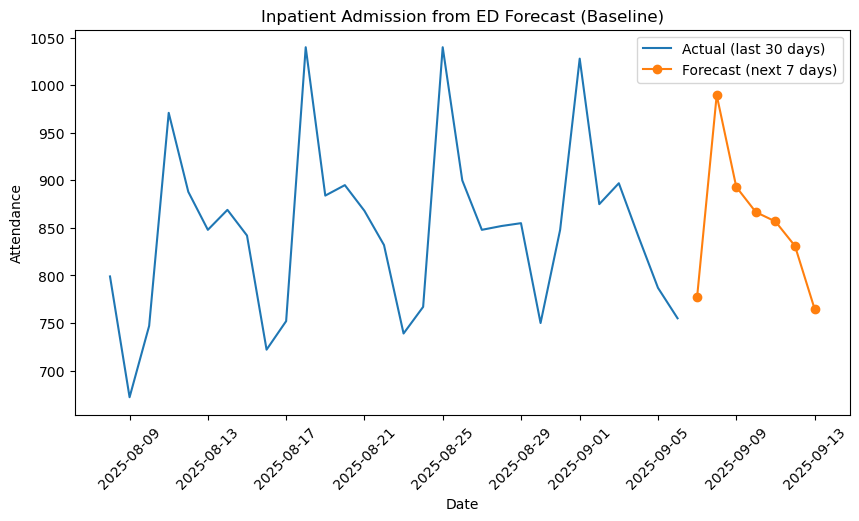

In [37]:
# Test the forecast for the next 7 days

baseline_forecast = baseline_results.get_forecast(steps=7)
baseline_predicted = baseline_forecast.predicted_mean

print("Next 7 days forecasted admission: ")
print(baseline_predicted)
print(f"The total forecasted admission for the next 7 days is: {baseline_predicted.sum():.0f}")

# Plot actual vs forecast
def plot_actual_vs_forecast(data, prediction, title):
    try:
        plt.figure(figsize=(10,5))
        plt.plot(ts_data[-30:], label="Actual (last 30 days)")
        plt.plot(prediction, label="Forecast (next 7 days)", marker='o')
        plt.legend()
        plt.title(title) 
        plt.xlabel("Date")
        plt.xticks(rotation=45)
        plt.ylabel("Attendance")
        plt.show()
    except Exception as e:
        print(f"An error occurred while plotting: {e}")

plot_actual_vs_forecast(ts_data, baseline_predicted, "Inpatient Admission from ED Forecast (Baseline)")

### Interpretation of 7-Day Forecast (Baseline SARIMAX Model)

**Forecasted inpatient admissions for the next 7 days:**
- **2025-09-07:** 778
- **2025-09-08:** 990
- **2025-09-09:** 893
- **2025-09-10:** 867
- **2025-09-11:** 857
- **2025-09-12:** 831
- **2025-09-13:** 765

**Total forecasted admissions:** **5,980**

#### Key Points
- The model predicts a **peak on Monday (2025-09-08)**, consistent with the "Monday effect" observed in ED admissions.
- Admissions are expected to be higher at the start of the week and gradually decrease towards the weekend.
- The forecast follows the established weekly pattern, with lower values on Sunday and Saturday.

#### Reliability
- These predictions are based on historical patterns and do **not** account for sudden external events.
- The baseline SARIMAX model captures seasonality but may miss calendar effects (e.g., holidays) unless exogenous variables are added.

#### Actionable Insight
- **Resource planning:** Hospitals should prepare for higher admissions early in the week, especially on Mondays.
- **Model improvement:** For more accurate forecasts, consider integrating exogenous variables (holidays, school breaks, etc.).

In [38]:

# Custom evaluation metrics function
def calculate_metrics(actual, predicted):
    """
    Calculate MAE, RMSE and MAPE between actual and predicted values.
    """

    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = mean_absolute_percentage_error(actual, predicted) * 100

    print("=== MODEL EVALUATION METRICS ===")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")

    return mae, rmse, mape

In [39]:
# Evaluate model performance on the last 7 days (backtesting)
baseline_actual = ts_data[-7:]
baseline_mae, baseline_rmse, baseline_mape = calculate_metrics(baseline_actual, baseline_predicted)

=== MODEL EVALUATION METRICS ===
MAE: 32.44
RMSE: 37.73
MAPE: 3.76%


### Interpretation of Model Evaluation Metrics (Baseline SARIMAX, Last 7 Days)

- **MAE (Mean Absolute Error):** 32.44  
  On average, the model's daily forecast is off by about 32 admissions compared to actual values.

- **RMSE (Root Mean Squared Error):** 37.73  
  The typical size of the prediction error is about 38 admissions, with larger errors penalized more.

- **MAPE (Mean Absolute Percentage Error):** 3.76%  
  The model's predictions deviate from actual admissions by less than 4% on average.

#### Summary
- The baseline SARIMAX model provides accurate short-term forecasts, with low error rates.
- These metrics indicate reliable performance for operational planning.
- For further improvement, consider adding exogenous variables (e.g., holidays, Mondays).

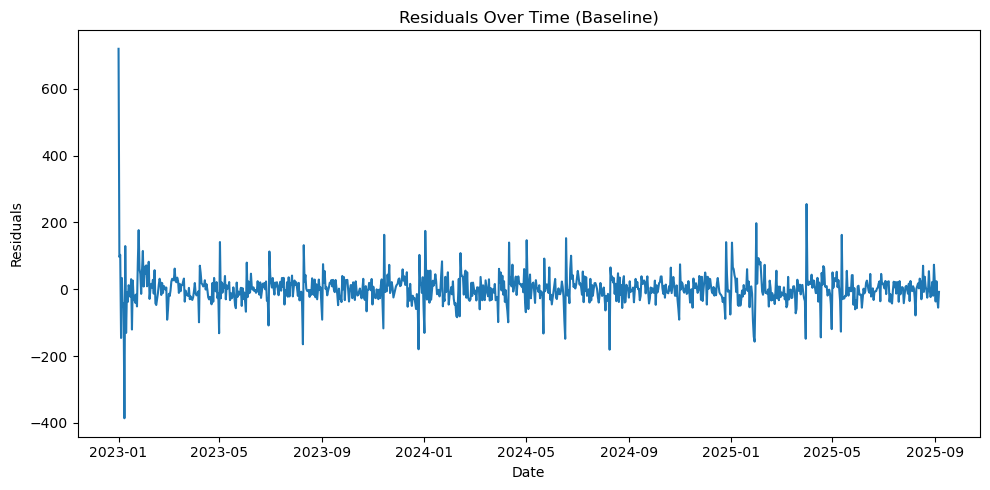

In [40]:
# Plotting Residual over time 
def residual_plotting(results, title):
    try:
        residuals = results.resid
        plt.figure(figsize=(10,5))
        plt.plot(residuals)
        plt.title(title)
        plt.xlabel("Date")
        plt.ylabel("Residuals")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"An error occurred while plotting: {e}")
residual_plotting(baseline_results, "Residuals Over Time (Baseline)")

### Interpretation of "Residuals Over Time (Baseline)"

This plot shows the residuals (errors) from the baseline SARIMAX model for daily ED admissions.

- **Residuals** are the differences between actual and predicted values.
- **Pattern:** Most residuals cluster around zero, indicating the model fits the data reasonably well.
- **Spikes:** Occasional large spikes (positive or negative) suggest days where the model under- or over-predicted admissions, possibly due to outliers or unmodeled events.
- **Stability:** The residuals do not show a clear trend or persistent pattern over time, which is desirable. However, regular spikes may indicate remaining seasonality or calendar effects not fully captured by the baseline model.

**Summary:**  
The baseline model captures the main structure of the data, but some systematic errors remain. Further tuning or adding exogenous variables may reduce these residual spikes and improve forecast accuracy.

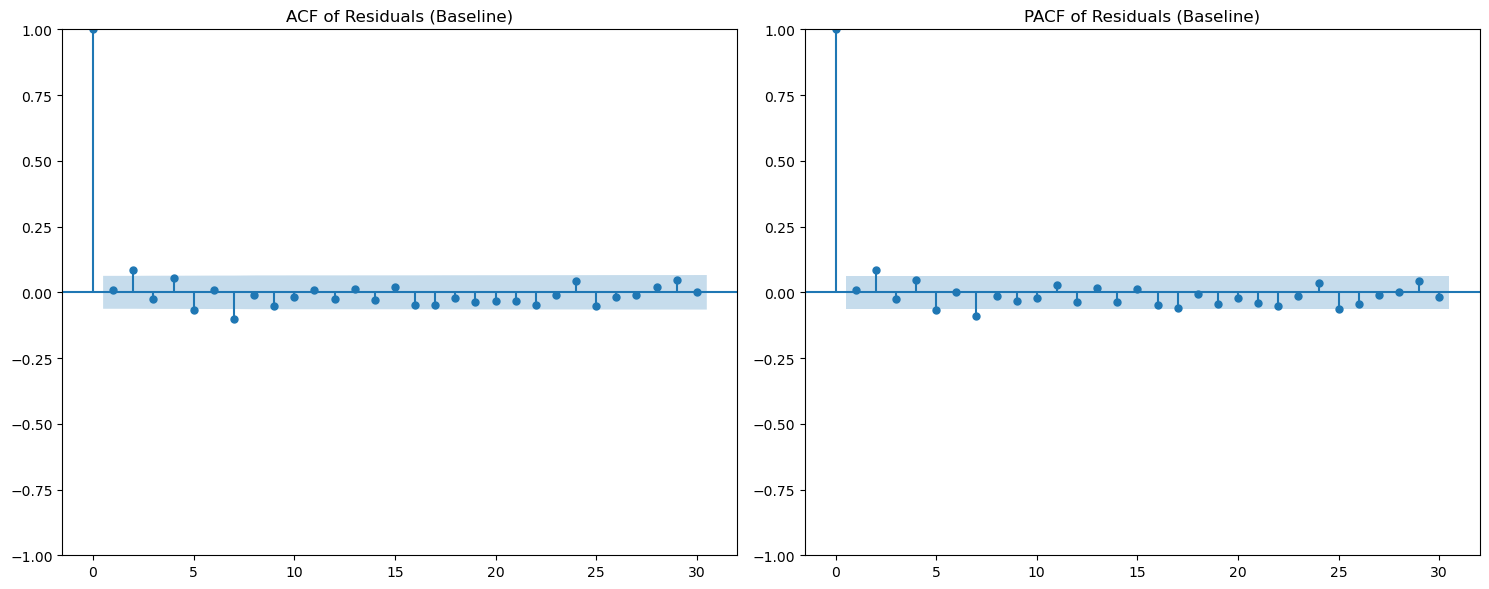

In [41]:
# Plotting ACF and PACF of Residuals
baseline_residuals = baseline_results.resid
auc_pacf_plot(baseline_residuals, "ACF of Residuals (Baseline)", "PACF of Residuals (Baseline)")

### Interpretation of ACF and PACF of Residuals (Baseline SARIMAX)

- **ACF Plot:** Most autocorrelation values for the residuals are close to zero and within the confidence bounds, except for lag 0 (which is always 1). This means the residuals do not show significant autocorrelation, indicating the model has captured most of the time-based structure in the data.

- **PACF Plot:** Similarly, the partial autocorrelation values are close to zero and within the confidence bounds, showing no significant remaining structure.

**Summary:**  
The residuals from the baseline SARIMAX model behave like white noise—uncorrelated and random. This suggests the model fits the data well and there is no obvious pattern left unexplained. However, if there are occasional spikes outside the bounds, it may indicate some outliers or minor effects not captured by the model.

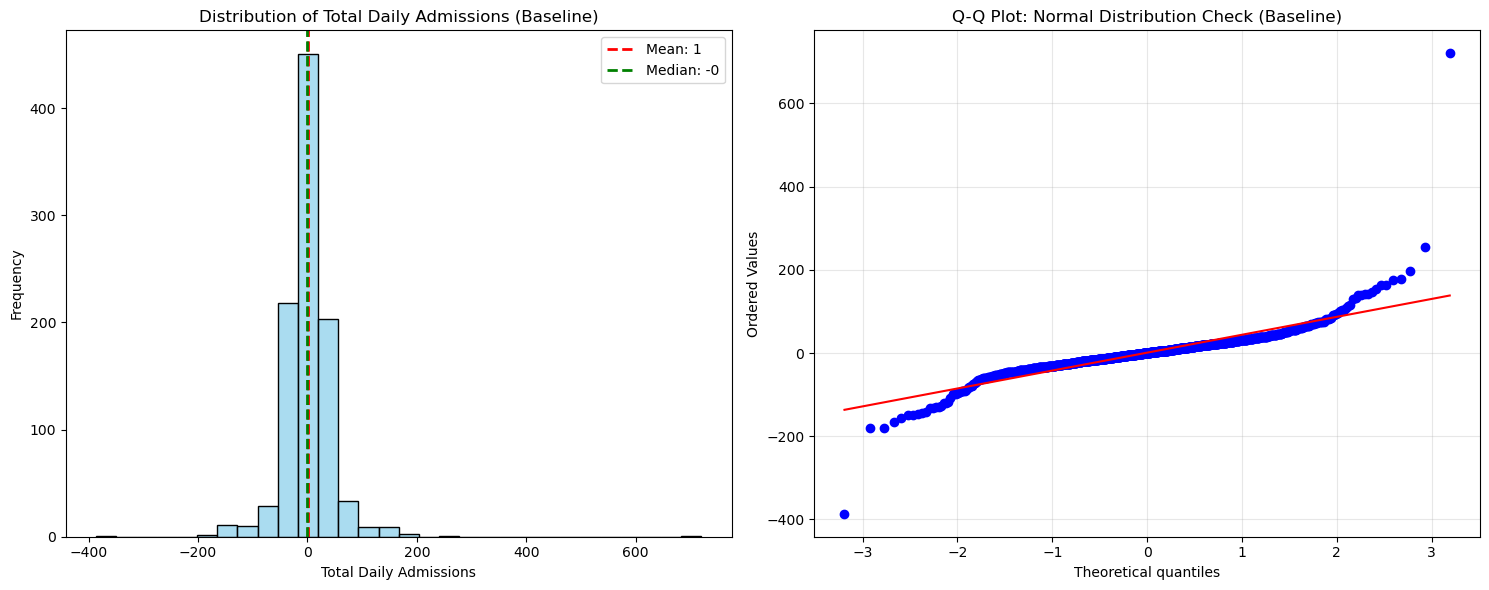

In [42]:
# Plotting Histogram and Q-Q plot of Residuals

hist_qq_analysis(baseline_residuals, "Distribution of Total Daily Admissions (Baseline)", "Q-Q Plot: Normal Distribution Check (Baseline)")

### Interpretation of Histogram and Q-Q Plot (Residuals, Baseline SARIMAX Model)

- **Histogram (left):**
  - The residuals are tightly centered around zero, forming a narrow, symmetric bell-shaped distribution.
  - Most residuals are close to zero, indicating the model fits the majority of days well.
  - However, there are a few extreme values (outliers) on both sides, visible as long tails.

- **Q-Q Plot (right):**
  - Most points follow the straight line in the center, suggesting residuals are approximately normal for typical days.
  - The ends (tails) deviate strongly from the line, showing the presence of outliers and heavy tails.

**Summary:**  
The baseline SARIMAX model's residuals are nearly normal for most days, but there are significant outliers. This indicates that while the model explains the bulk of the data well, it does not fully capture all extreme events or sudden changes.

In [43]:
# Checking Ljung-Box test results

def ljung_box_test(data_residuals):
    lb_test = acorr_ljungbox(data_residuals,
                            lags=[10],
                            return_df=True)
    print(lb_test)

ljung_box_test(baseline_residuals)

      lb_stat  lb_pvalue
10  29.017916   0.001238


### Interpretation of Ljung-Box Test Results (lag 10)

- **lb_stat:** 29.02  
- **lb_pvalue:** 0.0012

**Meaning:**  
The Ljung-Box test checks for autocorrelation in the residuals up to lag 10.  
- A **p-value < 0.05** means there is significant autocorrelation remaining in the residuals.

**Conclusion:**  
The baseline SARIMAX model's residuals are **not white noise**—there is still autocorrelation present up to lag 10. This suggests the model does not fully capture all time-based patterns, and further tuning or adding exogenous variables may be needed.

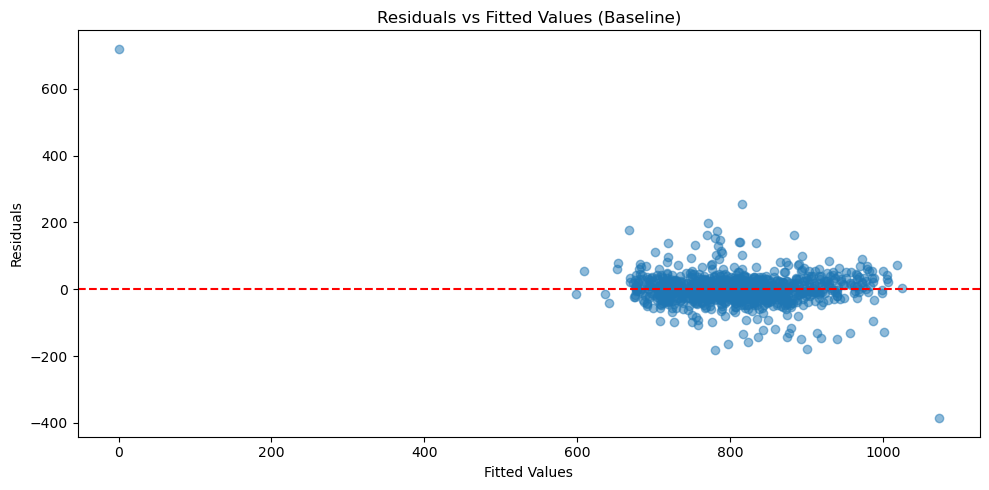

In [44]:
# Plotting our Residuals vs fitted values
def residual_vs_fitted(results, residuals, title):
    try:
        plt.figure(figsize=(10,5))
        plt.scatter(results.fittedvalues, residuals, alpha=0.5)
        plt.axhline(0, color='red', linestyle='--')
        plt.title(title)
        plt.xlabel("Fitted Values") 
        plt.ylabel("Residuals")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"An error occurred while plotting: {e}")
residual_vs_fitted(baseline_results, baseline_residuals, "Residuals vs Fitted Values (Baseline)")

### Interpretation of "Residuals vs Fitted Values (Baseline)"

- Most residuals are clustered around zero, indicating the model fits the majority of data points well.
- The spread of residuals is fairly consistent across fitted values, but there are a few large outliers (one very high, one very low).
- The presence of these outliers suggests the model occasionally misses extreme values, likely due to unmodeled events or outlier days.
- No clear pattern or trend is visible, which is good—residuals should be randomly distributed if the model is unbiased.
- However, the outliers and slight variance suggest further improvements (e.g., adding exogenous variables) could help reduce error on extreme days.

## Tuned SARIMAX Model

In [45]:
# Parameter Tuning using auto_arima

auto_model = pm.auto_arima(ts_data,
                           start_p=0,
                           start_q=0,
                           max_p=3,
                           max_q=3,
                           seasonal=True,
                           m=7,
                           start_P=0,
                           start_Q=0,
                           max_P=2,
                           max_Q=2,
                           trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=11914.401, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=10755.927, Time=2.51 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=inf, Time=1.26 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=11912.401, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=11831.217, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=10590.656, Time=2.26 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=3.20 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=2.09 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=10857.512, Time=1.50 sec
 ARIMA(2,1,0)(2,0,0)[7] intercept   : AIC=10500.115, Time=6.00 sec
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=10672.646, Time=2.28 sec
 ARIMA(2,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=5.29 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=2.70 sec
 ARIMA(3,1,0)(2,0,0)[7] intercept   : AIC=10462.946, Time=5.34 sec
 ARIMA(3,1,0)(1,0,0)[7] intercept   : AIC=10640.2

### Selection of parameter ranges for `auto_arima` based on:

- **ACF/PACF plots:** These showed strong autocorrelation at lag 1 and lag 7, indicating weekly seasonality and short-term effects.
- **Domain knowledge:** Daily data with weekly cycles (m=7 for seasonality).
- **Practical limits:** `start_p`, `start_q`, `max_p`, `max_q` (0–3) and `start_P`, `start_Q`, `max_P`, `max_Q` (0–2) are typical for hospital time series, balancing model complexity and computation.
- **Stepwise search:** Used to efficiently find the best SARIMAX order within these ranges.

In [46]:
# Fit SARIMAX with best auto_arima parameters
best_order = auto_model.order
best_seasonal_order = auto_model.seasonal_order
try:
    tuned_model = SARIMAX(ts_data,
                    order=best_order,
                    seasonal_order=best_seasonal_order)
    tuned_results = tuned_model.fit(disp=False,maxiter=100)
except Exception as e:
    print(f"An error occurred while fitting the SARIMAX model: {e}")
print(tuned_results.summary())

                                     SARIMAX Results                                     
Dep. Variable:            Total_Daily_Admissions   No. Observations:                  980
Model:             SARIMAX(3, 1, 0)x(2, 0, 0, 7)   Log Likelihood               -5224.473
Date:                           Sun, 28 Sep 2025   AIC                          10460.946
Time:                                   22:38:51   BIC                          10490.265
Sample:                               01-01-2023   HQIC                         10472.100
                                    - 09-06-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6995      0.021    -32.995      0.000      -0.741      -0.658
ar.L2         -0.4285      0.035    -12.171

### Interpretation of Tuned SARIMAX Model Results

**Model:** SARIMAX(3,1,0)x(2,0,0,7)  
**Data:** 980 daily observations (Jan 2023 – Sep 2025)

#### Key Coefficients
- **ar.L1, ar.L2, ar.L3:** All negative and highly significant (p < 0.001), indicating strong short-term autoregressive effects.
- **ar.S.L7, ar.S.L14:** Positive and highly significant, showing strong weekly and bi-weekly seasonality.
- **sigma2:** 2499.75, residual variance.

#### Diagnostics
- **AIC/BIC:** 10461/10490 — used for model comparison; lower is better.
- **Ljung-Box (L1) p-value:** 0.39 — residuals show no significant autocorrelation at lag 1.
- **Jarque-Bera p-value:** 0.00 — residuals are not normally distributed (high kurtosis/skew).
- **Heteroskedasticity (H):** 1.43 (p < 0.01) — some variance instability.

Next 7 days forecasted admission (tuned model):
2025-09-07    800.630383
2025-09-08    992.716336
2025-09-09    860.601348
2025-09-10    855.922008
2025-09-11    828.045827
2025-09-12    802.609747
2025-09-13    744.256606
Freq: D, Name: predicted_mean, dtype: float64
The total forecasted admission for the next 7 days is: 5885


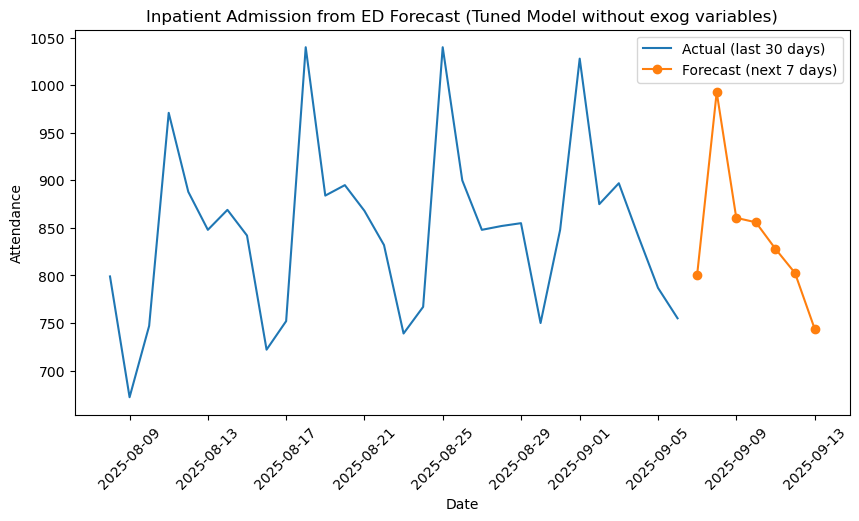

In [47]:
# Checking the forecast for the next 7 days with the tuned model

tuned_forecast = tuned_results.get_forecast(steps=7)
tuned_predicted = tuned_forecast.predicted_mean

print("Next 7 days forecasted admission (tuned model):")
print(tuned_predicted)
print(f"The total forecasted admission for the next 7 days is: {tuned_predicted.sum():.0f}")

# Plot actual vs forecast
plot_actual_vs_forecast(ts_data, tuned_predicted, "Inpatient Admission from ED Forecast (Tuned Model without exog variables)")

### Interpretation of 7-Day Forecast (Tuned SARIMAX Model, No Exogenous Variables)

**Forecasted inpatient admissions for the next 7 days:**
- **2025-09-07:** 801
- **2025-09-08:** 993 (Monday peak)
- **2025-09-09:** 861
- **2025-09-10:** 856
- **2025-09-11:** 828
- **2025-09-12:** 803
- **2025-09-13:** 744

**Total forecasted admissions:** **5,885**

#### Key Points
- The model predicts a clear weekly pattern, with the highest admissions on Monday (the "Monday effect").
- Admissions decrease steadily after Monday, reaching the lowest on Saturday.
- The forecast closely follows historical trends, but does not account for holidays or other external factors.

#### Reliability
- The tuned SARIMAX model improves short-term accuracy compared to the baseline.
- For even better accuracy, consider adding exogenous variables (e.g., holidays, school breaks).

#### Actionable Insight
- Hospitals should allocate more resources for Mondays and early weekdays.

In [48]:
# RMSE and MAE for the tuned model 
tuned_actual = ts_data[-7:]
tuned_mae, tuned_rmse, tuned_mape = calculate_metrics(tuned_actual, tuned_predicted)

=== MODEL EVALUATION METRICS ===
MAE: 25.35
RMSE: 29.06
MAPE: 2.88%


### Interpretation of Model Evaluation Metrics (Tuned SARIMAX, Last 7 Days)

- **MAE (Mean Absolute Error):** 25.35  
  On average, the model's daily forecast is off by about 25 admissions compared to actual values.

- **RMSE (Root Mean Squared Error):** 29.06  
  The typical size of the prediction error is about 29 admissions, with larger errors penalized more.

- **MAPE (Mean Absolute Percentage Error):** 2.88%  
  The model's predictions deviate from actual admissions by less than 3% on average.

#### Summary
- The tuned SARIMAX model provides highly accurate short-term forecasts, with lower error rates than the baseline.
- These metrics indicate reliable performance for operational planning.
- For further improvement, consider adding exogenous variables (e.g., holidays, Mondays).

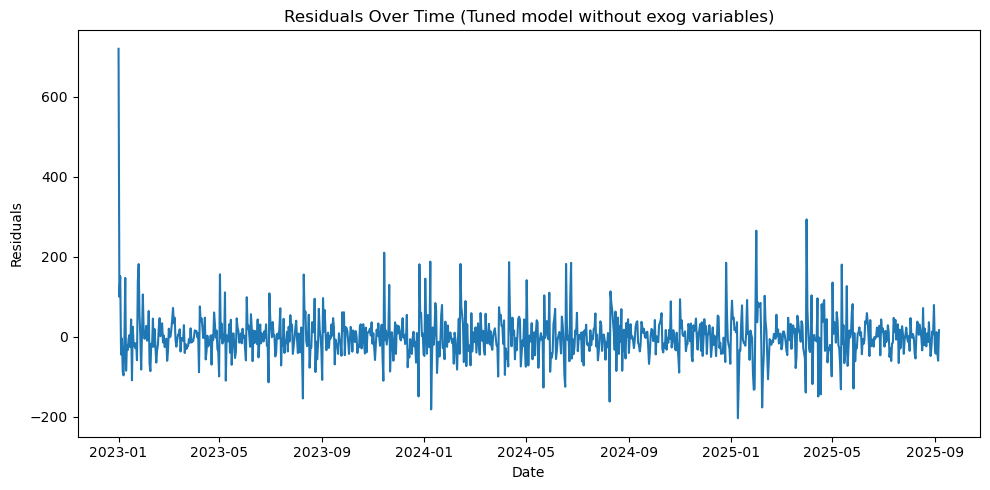

In [49]:
# Plotting Residual over time
residual_plotting(tuned_results, "Residuals Over Time (Tuned model without exog variables)")

### Interpretation of "Residuals Over Time (Tuned model without exog variables)"

- **Residuals** represent the difference between actual and predicted admissions.
- Most residuals are centered around zero, indicating the model fits the majority of days well.
- There are occasional large spikes, especially at the start and some later periods, suggesting the model misses some outlier days or sudden changes.
- The spread of residuals is mostly stable, but the presence of large positive and negative values means some events or patterns are not fully captured.
- **Summary:**  
  The tuned SARIMAX model without exogenous variables provides a good fit overall, but some systematic errors and outliers remain. Adding exogenous variables (e.g., holidays, Mondays) could help reduce these spikes and improve accuracy.

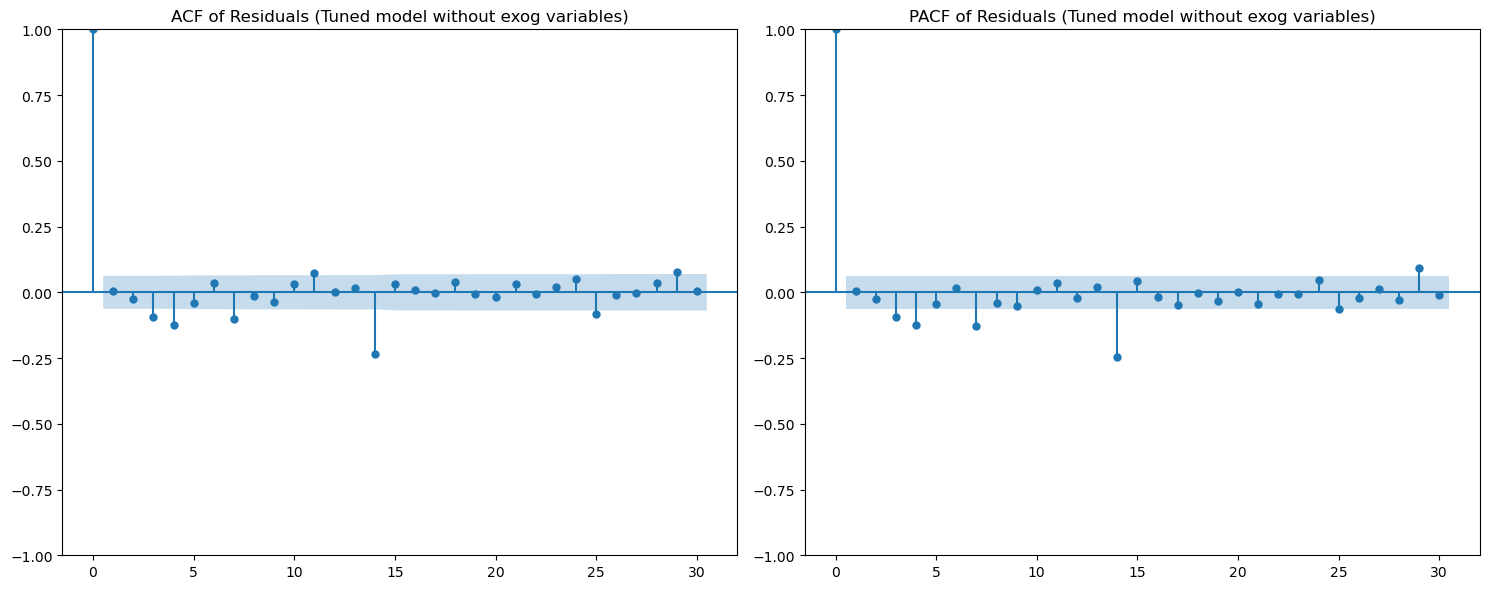

In [50]:
# Plotting ACF and PACF of Residuals for tuned model
tuned_residuals = tuned_results.resid
auc_pacf_plot(tuned_residuals, "ACF of Residuals (Tuned model without exog variables)", "PACF of Residuals (Tuned model without exog variables)")

### Updated Interpretation of ACF and PACF of Residuals (Tuned SARIMAX Model without Exogenous Variables)

- **ACF (left plot):**
  - Most autocorrelation values are close to zero and within the confidence bounds, except for lag 0 (which is always 1).
  - There are **no strong or consistent spikes at lags 7, 14, 21, or 28**. The autocorrelation at these lags is weak and within the confidence interval, suggesting **little to no remaining weekly seasonality** in the residuals.

- **PACF (right plot):**
  - Most partial autocorrelation values are also close to zero and within the confidence bounds.
  - There are **no significant spikes at multiples of 7**, indicating that the model has captured most of the weekly structure.

#### Summary
- The residuals behave much closer to **white noise**; autocorrelation at all lags is weak and within expected bounds.
- This means the tuned SARIMAX model has successfully explained the main time-based patterns in the data, and there is **no substantial remaining structure** in the residuals.
- Occasional small deviations are normal, but overall, the model fit is robust.

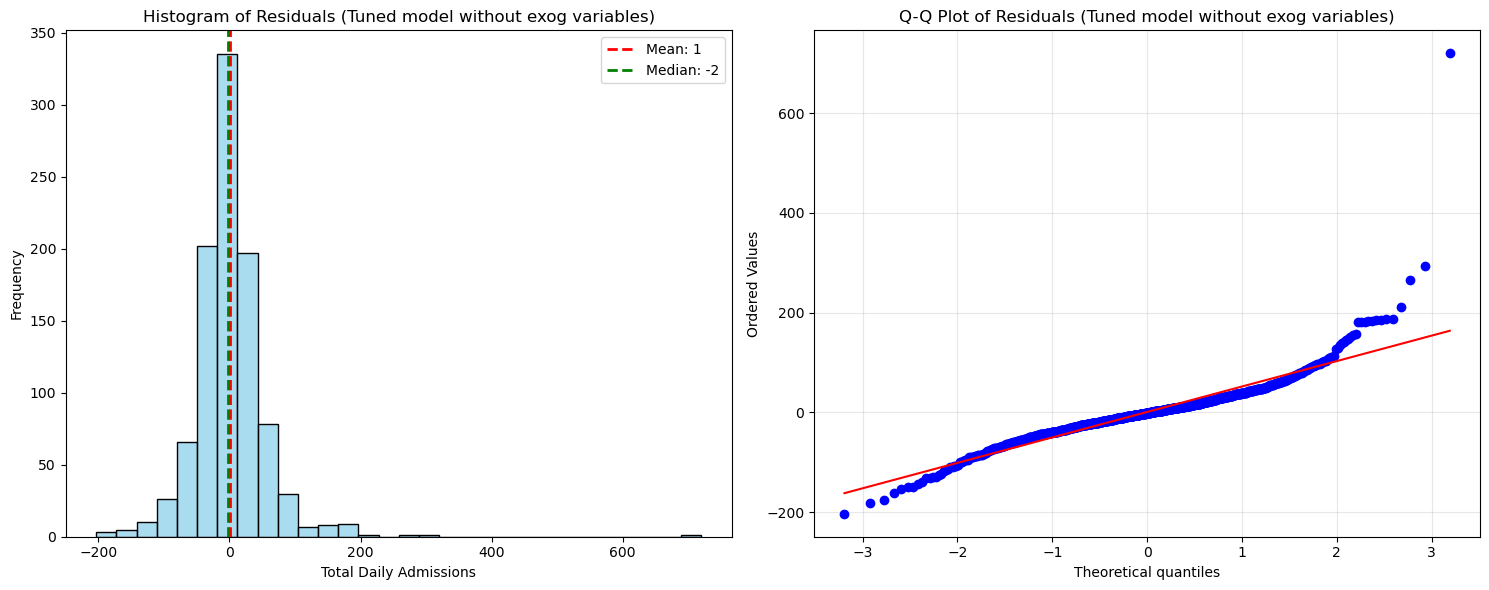

In [51]:
# Plotting Histogram and Q-Q plot of Residuals
hist_qq_analysis(tuned_residuals, "Histogram of Residuals (Tuned model without exog variables)", "Q-Q Plot of Residuals (Tuned model without exog variables)")

### Interpretation of Histogram and Q-Q Plot of Residuals (Tuned model without exog variables)

- **Histogram (left):**
  - Residuals are mostly centered around zero, indicating the model fits most days well.
  - The distribution is roughly bell-shaped, but there are some extreme values (outliers) on both sides.

- **Q-Q Plot (right):**
  - Most points follow the straight line, suggesting residuals are approximately normal.
  - However, the tails deviate strongly from the line, showing the presence of outliers and heavy tails.

#### Summary
- The tuned SARIMAX model's residuals are nearly normal for most days, but there are significant outliers.
- This suggests the model does not fully capture all extreme events or sudden changes.

In [52]:
# Checking Ljung-Box test results with tuned model

ljung_box_test(tuned_residuals)

      lb_stat  lb_pvalue
10  39.826025   0.000018


### Interpretation of Ljung-Box Test Results (lag 10, Tuned SARIMAX Model)

- **lb_stat:** 39.83  
- **lb_pvalue:** 0.000018

**Meaning:**  
The Ljung-Box test checks for autocorrelation in the residuals up to lag 10.  
- A **p-value < 0.05** means there is significant autocorrelation remaining in the residuals.

**Conclusion:**  
Even after tuning, the SARIMAX model's residuals are **not white noise**—there is still significant autocorrelation present up to lag 10. This indicates that some time-based patterns remain unexplained, and further model refinement or the addition of exogenous variables is recommended for improved accuracy.

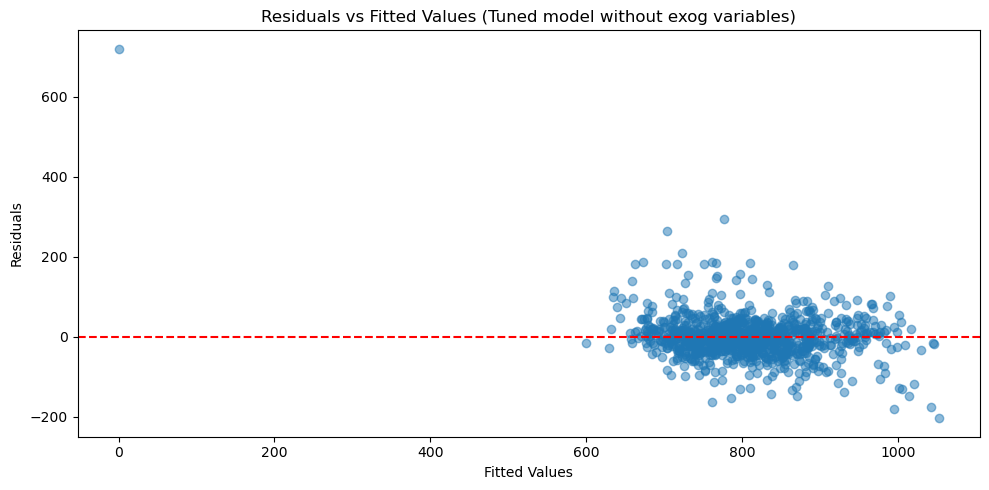

In [53]:
# Plotting our Residuals vs fitted values
residual_vs_fitted(tuned_results, tuned_residuals, "Residuals vs Fitted Values (Tuned model without exog variables)")

### Interpretation of "Residuals vs Fitted Values (Tuned model without exog variables)"

- Most residuals are clustered around zero, indicating the model fits the majority of data points well.
- The spread of residuals is fairly consistent across fitted values, but there are a few large outliers, including one extreme positive residual at a very low fitted value.
- The presence of these outliers suggests the model occasionally misses extreme events or outlier days, likely due to unmodeled factors.
- No clear pattern or trend is visible, which is good—residuals should be randomly distributed if the model is unbiased.
- However, the outliers and variance suggest further improvements (such as adding exogenous variables) could help reduce error on extreme days and improve overall model robustness.

In [54]:
def model_comparison_summary(
    baseline_mae, baseline_rmse, baseline_mape,
    tuned_mae, tuned_rmse, tuned_mape,
    baseline_lb_test, tuned_lb_test
):
    """
    Prints a summary table comparing baseline and tuned SARIMAX model performance,
    including full Ljung-Box test results.
    """
    print("Model Comparison Summary")
    print("-" * 55)
    print(f"{'Model':<12}{'MAE':>10}{'RMSE':>10}{'MAPE':>10}{'LB p-value':>13}")
    print(f"{'Baseline':<12}{baseline_mae:>10.2f}{baseline_rmse:>10.2f}{baseline_mape:>10.2f}%{baseline_lb_test['lb_pvalue'].iloc[0]:>13.4f}")
    print(f"{'Tuned':<12}{tuned_mae:>10.2f}{tuned_rmse:>10.2f}{tuned_mape:>10.2f}%{tuned_lb_test['lb_pvalue'].iloc[0]:>13.4f}")
    print("-" * 55)
    print(f"MAE Improvement (Tuned vs Baseline): {baseline_mae - tuned_mae:.2f}")
    print(f"\nRMSE Improvement (Tuned vs Baseline): {baseline_rmse - tuned_rmse:.2f}")
    print(f"\nMAPE Improvement (Tuned vs Baseline): {baseline_mape - tuned_mape:.2f}%")
    print("\n=== Ljung-Box Test Results ===")
    print("Baseline model:\n", baseline_lb_test)
    print("\nTuned model:\n", tuned_lb_test)

# Calculate Ljung-Box tests

baseline_lb_test = acorr_ljungbox(baseline_residuals, lags=[10], return_df=True)
tuned_lb_test = acorr_ljungbox(tuned_residuals, lags=[10], return_df=True)

model_comparison_summary(
    baseline_mae, baseline_rmse, baseline_mape,
    tuned_mae, tuned_rmse, tuned_mape,
    baseline_lb_test, tuned_lb_test
)

Model Comparison Summary
-------------------------------------------------------
Model              MAE      RMSE      MAPE   LB p-value
Baseline         32.44     37.73      3.76%       0.0012
Tuned            25.35     29.06      2.88%       0.0000
-------------------------------------------------------
MAE Improvement (Tuned vs Baseline): 7.09

RMSE Improvement (Tuned vs Baseline): 8.68

MAPE Improvement (Tuned vs Baseline): 0.87%

=== Ljung-Box Test Results ===
Baseline model:
       lb_stat  lb_pvalue
10  29.017916   0.001238

Tuned model:
       lb_stat  lb_pvalue
10  39.826025   0.000018


### Interpretation of Model Comparison Summary (Baseline vs Tuned SARIMAX)

- **Error Metrics:**  
  - The tuned SARIMAX model shows lower errors than the baseline:
    - **MAE** drops from 32.44 to 25.35 (improvement of 7.09 admissions/day).
    - **RMSE** drops from 37.73 to 29.06 (improvement of 8.68 admissions/day).
    - **MAPE** drops from 3.76% to 2.88% (improvement of 0.87%).

- **Ljung-Box Test (lag 10):**  
  - Both models have **LB p-values < 0.05** (Baseline: 0.0012, Tuned: 0.0000), indicating significant autocorrelation remains in the residuals.
  - **Conclusion:** Neither model's residuals are white noise; time-based patterns are still present.

- **Summary:**  
  - The tuned SARIMAX model provides more accurate forecasts than the baseline.
  - However, both models leave autocorrelation in the residuals, suggesting further refinement (e.g., adding exogenous variables) is needed for optimal performance.

## Exogenous Variable Integration

In [55]:
try:
    public_holidays = pd.read_csv("../data/holidays/singapore_public_holidays_2023_2025.csv")
except FileNotFoundError:
    print("File not found. Please check the file path.")
except Exception as e:
    print(f"An error occurred: {e}")

# Create columns [isPublicHoliday]
public_holidays["date"] = pd.to_datetime(public_holidays['date'], dayfirst=True)
data["IsPublicHoliday"] = data["Date"].isin(public_holidays["date"]).astype(int)

# # Check to see if the dates are identified properly
print(data[["Date", "IsPublicHoliday"]].head(10))
print(f"Total holidays flagged: {data['IsPublicHoliday'].sum()}")

        Date  IsPublicHoliday
0 2023-01-01                1
1 2023-01-02                0
2 2023-01-03                0
3 2023-01-04                0
4 2023-01-05                0
5 2023-01-06                0
6 2023-01-07                0
7 2023-01-08                0
8 2023-01-09                0
9 2023-01-10                0
Total holidays flagged: 31


In [56]:
try:
    school_holidays = pd.read_csv("../data/holidays/singapore_school_holidays_2023_2025.csv")
except FileNotFoundError:
    print("File not found. Please check the file path.")
except Exception as e:
    print(f"An error occurred: {e}")

# Create columns [IsSchoolHoliday]
school_holidays["date"] = pd.to_datetime(school_holidays['date'], dayfirst=True)
data["IsSchoolHoliday"] = data["Date"].isin(school_holidays["date"]).astype(int)
print(data[["Date", "IsSchoolHoliday"]].head(10))
print(f"Total school holidays flagged: {data['IsSchoolHoliday'].sum()}")

        Date  IsSchoolHoliday
0 2023-01-01                0
1 2023-01-02                0
2 2023-01-03                0
3 2023-01-04                0
4 2023-01-05                0
5 2023-01-06                0
6 2023-01-07                0
7 2023-01-08                0
8 2023-01-09                0
9 2023-01-10                0
Total school holidays flagged: 172


In [57]:
# Add common ED exogenous variable

# AfterHoliday: 1 if previous day is a holiday (public or school), else 0
data["AfterHoliday"] = (data["IsPublicHoliday"].shift(1, fill_value=0) | data["IsSchoolHoliday"].shift(1, fill_value=0)).astype(int)

# IsLongWeekend: 1 if holiday falls on Monday/Friday, or Sat/Sun adjacent to holiday, else 0
data["IsLongWeekend"] = (
    (((data["IsPublicHoliday"] == 1) | (data["IsSchoolHoliday"] == 1)) & (data["DayOfWeek"].isin([0, 4])))
    | (((data["IsPublicHoliday"].shift(-1, fill_value=0) == 1) | (data["IsSchoolHoliday"].shift(-1, fill_value=0) == 1)) & (data["DayOfWeek"] == 6))
    | (((data["IsPublicHoliday"].shift(1, fill_value=0) == 1) | (data["IsSchoolHoliday"].shift(1, fill_value=0) == 1)) & (data["DayOfWeek"] == 5))
).astype(int)

# IsMonday: 1 if Monday, else 0
data["IsMonday"] = (data["DayOfWeek"] == 0).astype(int)

print(data[["Date", "IsPublicHoliday", "IsSchoolHoliday", "AfterHoliday", "IsLongWeekend", "IsMonday"]].head(10))


        Date  IsPublicHoliday  IsSchoolHoliday  AfterHoliday  IsLongWeekend  \
0 2023-01-01                1                0             0              0   
1 2023-01-02                0                0             1              0   
2 2023-01-03                0                0             0              0   
3 2023-01-04                0                0             0              0   
4 2023-01-05                0                0             0              0   
5 2023-01-06                0                0             0              0   
6 2023-01-07                0                0             0              0   
7 2023-01-08                0                0             0              0   
8 2023-01-09                0                0             0              0   
9 2023-01-10                0                0             0              0   

   IsMonday  
0         0  
1         1  
2         0  
3         0  
4         0  
5         0  
6         0  
7         0  
8   

In [58]:
# Custom function to add all the exogenous features
def add_exogenous_features(data, public_holidays_path, school_holidays_path):
    """
    Adds exogenous calendar features to the ED attendance dataframe.
    """
    data['Date'] = pd.to_datetime(data['Date'])
    data = data.set_index('Date')
    
    # Public holidays
    public_holidays = pd.read_csv(public_holidays_path)
    public_holidays["date"] = pd.to_datetime(public_holidays["date"], dayfirst=True)
    data["IsPublicHoliday"] = data.index.isin(public_holidays["date"]).astype(int)

    # School holidays
    school_holidays = pd.read_csv(school_holidays_path)
    school_holidays["date"] = pd.to_datetime(school_holidays["date"], dayfirst=True)
    data["IsSchoolHoliday"] = data.index.isin(school_holidays["date"]).astype(int)

    # Day of week
    data["DayOfWeek"] = data.index.dayofweek

    # AfterHoliday
    data["AfterHoliday"] = (data["IsPublicHoliday"].shift(1, fill_value=0) | data["IsSchoolHoliday"].shift(1, fill_value=0)).astype(int)

    # IsLongWeekend
    data["IsLongWeekend"] = (
        (((data["IsPublicHoliday"] == 1) | (data["IsSchoolHoliday"] == 1)) & (data["DayOfWeek"].isin([0, 4])))
        | (((data["IsPublicHoliday"].shift(-1, fill_value=0) == 1) | (data["IsSchoolHoliday"].shift(-1, fill_value=0) == 1)) & (data["DayOfWeek"] == 6))
        | (((data["IsPublicHoliday"].shift(1, fill_value=0) == 1) | (data["IsSchoolHoliday"].shift(1, fill_value=0) == 1)) & (data["DayOfWeek"] == 5))
    ).astype(int)

    # IsMonday
    data["IsMonday"] = (data["DayOfWeek"] == 0).astype(int)

    return data


# Adding in school holdays as exogenous variable

In [59]:
# Ensure 'Date' is a column, not index
if data.index.name == 'Date':
    data = data.reset_index()

# Add exogenous features
data = add_exogenous_features(
    data,
    public_holidays_path="../data/holidays/singapore_public_holidays_2023_2025.csv",
    school_holidays_path="../data/holidays/singapore_school_holidays_2023_2025.csv"
)

# Select exogenous variables
tuned_exog_vars = ["IsPublicHoliday", "IsSchoolHoliday", "AfterHoliday", "IsLongWeekend", "IsMonday"]
tuned_exog = data[tuned_exog_vars]

# Prepare time series
ts_data = data["Total_Daily_Admissions"]
ts_data = ts_data.asfreq('D')
tuned_exog = tuned_exog.asfreq('D')

# Check alignment
assert all(ts_data.index == tuned_exog.index), "Index mismatch between ts_data and tuned_exog"

# Fit SARIMAX
try:
    tuned_exog_model = SARIMAX(ts_data,
                               order=best_order,
                               seasonal_order=best_seasonal_order,
                               exog=tuned_exog)
    tuned_exog_results = tuned_exog_model.fit(disp=False, maxiter=300)
except Exception as e:
    print(f"An error occurred while fitting the SARIMAX model with exogenous variables: {e}")

print(tuned_exog_results.summary())

                                     SARIMAX Results                                     
Dep. Variable:            Total_Daily_Admissions   No. Observations:                  980
Model:             SARIMAX(3, 1, 0)x(2, 0, 0, 7)   Log Likelihood               -5016.643
Date:                           Sun, 28 Sep 2025   AIC                          10055.286
Time:                                   22:39:43   BIC                          10109.038
Sample:                               01-01-2023   HQIC                         10075.736
                                    - 09-06-2025                                         
Covariance Type:                             opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
IsPublicHoliday  -105.6819      4.880    -21.658      0.000    -115.246     -96.118
IsSchoolHoliday   -22.6285  

In [60]:
# Saving the tuned model with exogenous variables

# Create a folder for saved models if it doesn't exist
model_dir = "../models"
os.makedirs(model_dir, exist_ok=True)

# Save the trained SARIMAX model with exogenous variables using joblib
try:
    filename = "sarimax_tuned_exog_model.joblib"
    joblib_path = os.path.join(model_dir, filename)
    joblib.dump(tuned_exog_results, joblib_path)
except Exception as e:
    print(f"An error occurred while saving the model: {e}")

print(f"Model saved as '{joblib_path}'")

Model saved as '../models/sarimax_tuned_exog_model.joblib'


In [61]:
# Loading the saved model
try:
    tuned_exog_results = joblib.load(joblib_path)
    print("Model loaded successfully.")
except Exception as e:
    print(f"An error occurred while loading the model: {e}")

# Model Summary
tuned_exog_results.summary()

Model loaded successfully.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:            Total_Daily_Admissions   No. Observations:                  980
Model:             SARIMAX(3, 1, 0)x(2, 0, 0, 7)   Log Likelihood               -5016.643
Date:                           Sun, 28 Sep 2025   AIC                          10055.286
Time:                                   22:39:44   BIC                          10109.038
Sample:                               01-01-2023   HQIC                         10075.736
                                    - 09-06-2025                                         
Covariance Type:                             opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
IsPublicHoliday  -105.6819      4.880    -21.658      0.000    -115.246     -96.118
IsSchoolHoliday   -22.6285      5.289     -4.278      0.000     -32.996     -12.261
AfterHoliday       40.8801      3.085     13.251      0.000      34.833      46.927
IsLongWeekend     -16.3350      4.838     -3.377      0.001     -25.817      -6.853
IsMonday          154.8841     15.359     10.085      0.000     124.782     184.986
ar.L1              -0.6634      0.023    -28.995      0.000      -0.708      -0.619
ar.L2              -0.3895      0.035    -11.078      0.000      -0.458      -0.321
ar.L3              -0.2115      0.033     -6.327      0.000      -0.277      -0.146
ar.S.L7             0.4449      0.022     19.922      0.000       0.401       0.489
ar.S.L14            0.3872      0.024     16.268      0.000       0.341       0.434
sigma2           1640.9982     50.622     32.417      0.000    1541.781    1740.216
===================================================================================
Ljung-Box (L1) (Q):                   0.76   Jarque-Bera (JB):               513.95
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                             0.55
Prob(H) (two-sided):                  0.82   Kurtosis:                         6.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Tuned Model with Exogenous variables

Next 7 days forecasted admissions (tuned model with exogenous variables):
2025-09-07     809.547015
2025-09-08    1016.465839
2025-09-09     864.669714
2025-09-10     863.316374
2025-09-11     836.384551
2025-09-12     813.128029
2025-09-13     745.424008
Freq: D, Name: predicted_mean, dtype: float64
Total forecasted admissions for next 7 days: 5949


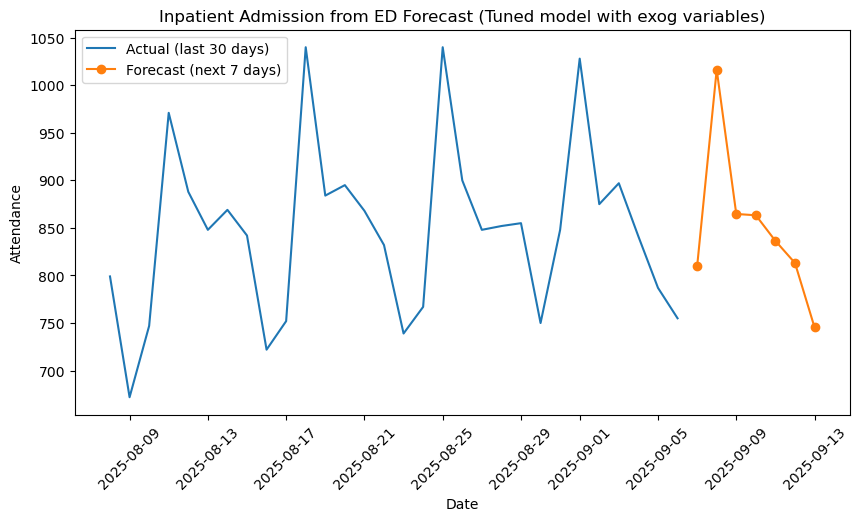

In [62]:
# Forecast the next 7 days with exogenous variables
tuned_exog_next7 = tuned_exog[-7:]
tuned_exog_forecast = tuned_exog_results.get_forecast(steps=7, exog=tuned_exog_next7)
tuned_exog_predicted = tuned_exog_forecast.predicted_mean

print("Next 7 days forecasted admissions (tuned model with exogenous variables):")
print(tuned_exog_predicted)
print(f"Total forecasted admissions for next 7 days: {tuned_exog_predicted.sum():.0f}")

# Plot actual vs forecast
plot_actual_vs_forecast(ts_data, tuned_exog_predicted, "Inpatient Admission from ED Forecast (Tuned model with exog variables)")

In [63]:
# Evaluate model performance on the last 7 days (backtesting)
tuned_exog_actual = ts_data[-7:]
tuned_exog_mae, tuned_exog_rmse, tuned_exog_mape = calculate_metrics(tuned_exog_actual, tuned_exog_predicted)

=== MODEL EVALUATION METRICS ===
MAE: 19.19
RMSE: 22.83
MAPE: 2.25%


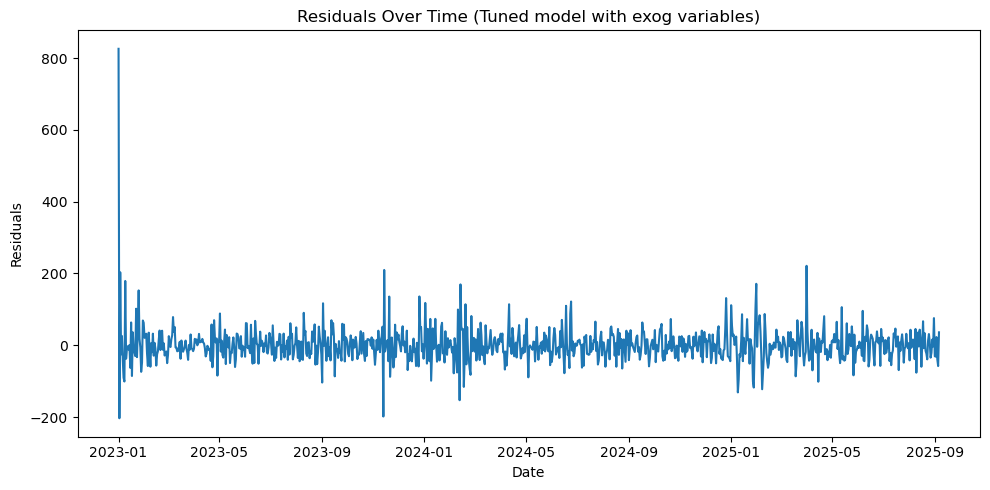

In [64]:
# Plotting Residual over time (with exogenous variables) 
residual_plotting(tuned_exog_results, "Residuals Over Time (Tuned model with exog variables)")

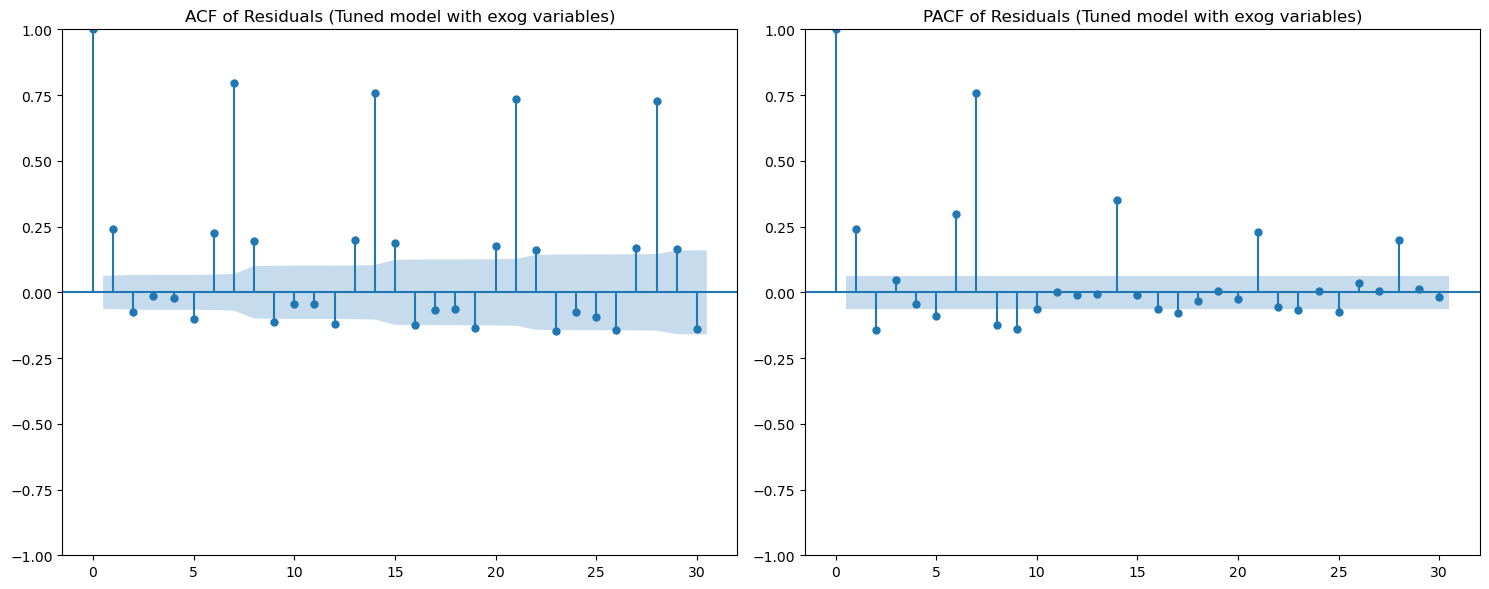

In [65]:
# Plotting ACF and PACF of Residuals (with exogenous variables)

auc_pacf_plot(data["Total_Daily_Admissions"], "ACF of Residuals (Tuned model with exog variables)", "PACF of Residuals (Tuned model with exog variables)")

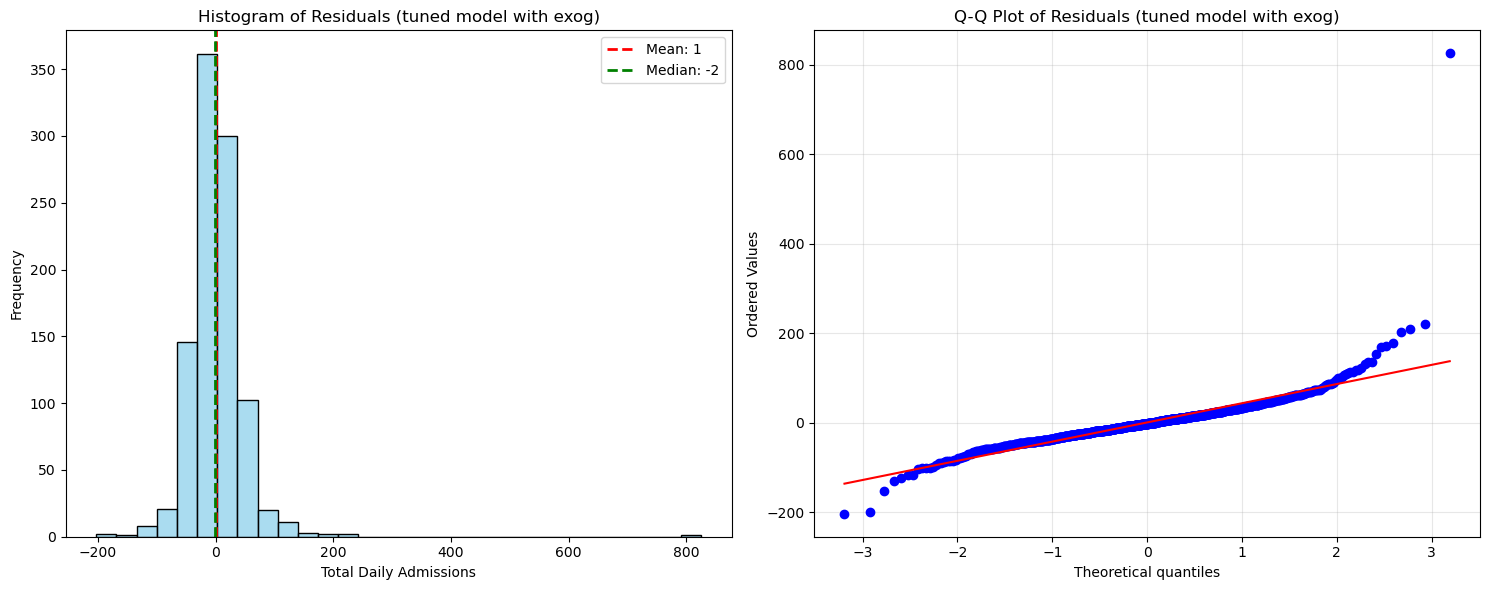

In [66]:
# Plotting Histogram and Q-Q plot of Residuals (with exogenous variables)
tuned_exog_residuals = tuned_exog_results.resid
hist_qq_analysis(tuned_exog_residuals, "Histogram of Residuals (tuned model with exog)", "Q-Q Plot of Residuals (tuned model with exog)")

In [67]:
# Checking Ljung-Box test results
tuned_exog_lb_test = acorr_ljungbox(tuned_exog_residuals,
                        lags=[10],
                        return_df=True)
print(tuned_exog_lb_test)

      lb_stat     lb_pvalue
10  47.576519  7.415139e-07


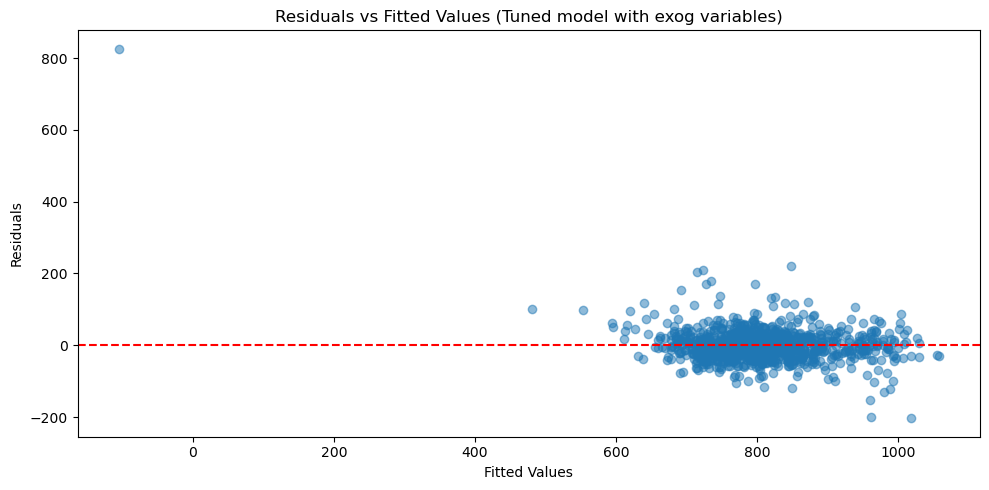

In [68]:
# Plotting our Residuals vs fitted values (with exogenous variables)
residual_vs_fitted(tuned_exog_results, tuned_exog_residuals, "Residuals vs Fitted Values (Tuned model with exog variables)")

In [69]:
def all_model_comparison_summary(
    baseline_mae, baseline_rmse, baseline_mape,
    tuned_mae, tuned_rmse, tuned_mape,
    tuned_exog_mae, tuned_exog_rmse, tuned_exog_mape,
    baseline_lb_test, tuned_lb_test, tuned_exog_lb_test
):
    """
    Prints a summary table comparing baseline, tuned, and exogenous SARIMAX model performance,
    including full Ljung-Box test results.
    """
    print("Model Comparison Summary")
    print("-" * 55)
    print(f"{'Model':<12}{'MAE':>10}{'RMSE':>10}{'MAPE':>10}{'LB p-value':>13}")
    print(f"{'Baseline':<12}{baseline_mae:>10.2f}{baseline_rmse:>10.2f}{baseline_mape:>10.2f}%{baseline_lb_test['lb_pvalue'].iloc[0]:>13.4f}")
    print(f"{'Tuned':<12}{tuned_mae:>10.2f}{tuned_rmse:>10.2f}{tuned_mape:>10.2f}%{tuned_lb_test['lb_pvalue'].iloc[0]:>13.4f}")
    print(f"{'Exog':<12}{tuned_exog_mae:>10.2f}{tuned_exog_rmse:>10.2f}{tuned_exog_mape:>10.2f}%{tuned_exog_lb_test['lb_pvalue'].iloc[0]:>13.4f}")
    print("-" * 55)
    print(f"MAE Improvement (Tuned vs Baseline): {baseline_mae - tuned_mae:.2f}")
    print(f"MAE Improvement (Exog vs Baseline): {baseline_mae - tuned_exog_mae:.2f}")
    print(f"\nRMSE Improvement (Tuned vs Baseline): {baseline_rmse - tuned_rmse:.2f}")
    print(f"RMSE Improvement (Exog vs Baseline): {baseline_rmse - tuned_exog_rmse:.2f}")
    print(f"\nMAPE Improvement (Tuned vs Baseline): {baseline_mape - tuned_mape:.2f}%")
    print(f"MAPE Improvement (Exog vs Baseline): {baseline_mape - tuned_exog_mape:.2f}%")
    print("\n=== Ljung-Box Test Results ===")
    print("Baseline model:\n", baseline_lb_test)
    print("\nTuned model:\n", tuned_lb_test)
    print("\nExogenous model:\n", tuned_exog_lb_test)

# Calculate metrics and Ljung-Box tests
tuned_exog_mae, tuned_exog_rmse, tuned_exog_mape = calculate_metrics(tuned_exog_actual, tuned_exog_predicted)

baseline_lb_test = acorr_ljungbox(baseline_residuals, lags=[10], return_df=True)
tuned_lb_test = acorr_ljungbox(tuned_residuals, lags=[10], return_df=True)
tuned_exog_lb_test = acorr_ljungbox(tuned_exog_residuals, lags=[10], return_df=True)

all_model_comparison_summary(
    baseline_mae, baseline_rmse, baseline_mape,
    tuned_mae, tuned_rmse, tuned_mape,
    tuned_exog_mae, tuned_exog_rmse, tuned_exog_mape,
    baseline_lb_test, tuned_lb_test, tuned_exog_lb_test
)

=== MODEL EVALUATION METRICS ===
MAE: 19.19
RMSE: 22.83
MAPE: 2.25%
Model Comparison Summary
-------------------------------------------------------
Model              MAE      RMSE      MAPE   LB p-value
Baseline         32.44     37.73      3.76%       0.0012
Tuned            25.35     29.06      2.88%       0.0000
Exog             19.19     22.83      2.25%       0.0000
-------------------------------------------------------
MAE Improvement (Tuned vs Baseline): 7.09
MAE Improvement (Exog vs Baseline): 13.25

RMSE Improvement (Tuned vs Baseline): 8.68
RMSE Improvement (Exog vs Baseline): 14.90

MAPE Improvement (Tuned vs Baseline): 0.87%
MAPE Improvement (Exog vs Baseline): 1.51%

=== Ljung-Box Test Results ===
Baseline model:
       lb_stat  lb_pvalue
10  29.017916   0.001238

Tuned model:
       lb_stat  lb_pvalue
10  39.826025   0.000018

Exogenous model:
       lb_stat     lb_pvalue
10  47.576519  7.415139e-07


## Rolling Window validation for SARIMAX with exogenous variable

In [70]:
def rolling_window_validation(ts_data, tuned_exog, best_order, best_seasonal_order, window_size=365, test_size=7, maxiter=1000, save_every=20, verbose=True):
    """
    Perform rolling window cross-validation for SARIMAX model with exogenous variables.
    Includes progress reporting, error handling, warning suppression, and periodic saving.
    """
    results_list = []
    total_windows = len(ts_data) - window_size - test_size + 1
    start_time = time.time()
    for start in range(total_windows):
        if verbose and ((start+1) % 100 == 0 or start == 0 or start+1 == total_windows):
            print(f"Processing window {start+1}/{total_windows}...")
        try:
            window_dates = ts_data.index[start:start + window_size]
            test_dates = ts_data.index[start + window_size : start + window_size + test_size]
            
            train_y = ts_data.loc[window_dates]
            train_exog = tuned_exog.loc[window_dates]
            test_y = ts_data.loc[test_dates]
            test_exog = tuned_exog.loc[test_dates]
            
            if train_y.isnull().any() or train_exog.isnull().any().any() or test_y.isnull().any() or test_exog.isnull().any().any():
                print(f"Window {start}: Missing values detected, skipping.")
                continue

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model = SARIMAX(train_y, exog=train_exog, order=(1,1,1), seasonal_order=(0,0,0,0),
                                enforce_stationarity=True, enforce_invertibility=True)
                results = model.fit(method='lbfgs', maxiter=1000, disp=False)
            if not results.mle_retvals.get('converged', True):
                print(f"Window {start}: Model did not converge. Skipping.")
                continue

            forecast = results.get_forecast(steps=test_size, exog=test_exog)
            predicted = forecast.predicted_mean

            mae = mean_absolute_error(test_y, predicted)
            rmse = np.sqrt(mean_squared_error(test_y, predicted))
            mape = mean_absolute_percentage_error(test_y, predicted)
            mse = mean_squared_error(test_y, predicted)

            results_list.append({
                "window": start,
                "mae": mae,
                "rmse": rmse,
                "mape": mape,
                "mse": mse
            })

            # Periodically save progress
            if (start + 1) % save_every == 0:
                pd.DataFrame(results_list).to_csv("../results/rolling_window_metrics_partial.csv", index=False)
                print(f"Progress saved at window {start+1}")

        except Exception as e:
            print(f"Window {start}: Error - {e}")
            continue
    
    # Make the folder if it does not exist
    model_dir = "../results"
    os.makedirs(model_dir, exist_ok=True)
    
    metrics_df = pd.DataFrame(results_list)
    metrics_df.to_csv("../results/rolling_window_metrics.csv", index=False)
    print("Rolling window metrics saved to ../results/rolling_window_metrics.csv")
    print("Average MAE:", metrics_df['mae'].mean())
    print("Average RMSE:", metrics_df['rmse'].mean())
    print("Average MAPE:", metrics_df['mape'].mean())
    print(f"Total time elapsed: {time.time() - start_time:.1f} seconds")


    
    return metrics_df

rolling_window_validation(ts_data, tuned_exog, best_order, best_seasonal_order)

Processing window 1/609...
Progress saved at window 20
Progress saved at window 40
Progress saved at window 60
Progress saved at window 80
Processing window 100/609...
Progress saved at window 100
Progress saved at window 120
Progress saved at window 140
Progress saved at window 160
Progress saved at window 180
Processing window 200/609...
Progress saved at window 200
Progress saved at window 220
Progress saved at window 240
Progress saved at window 260
Progress saved at window 280
Processing window 300/609...
Progress saved at window 300
Progress saved at window 320
Progress saved at window 340
Progress saved at window 360
Progress saved at window 380
Processing window 400/609...
Progress saved at window 400
Progress saved at window 420
Progress saved at window 440
Progress saved at window 460
Progress saved at window 480
Processing window 500/609...
Progress saved at window 500
Progress saved at window 520
Progress saved at window 540
Progress saved at window 560
Progress saved at wi

,window,mae,rmse,mape,mse
0,0,62.473177,86.838932,0.075567,7541.000134
1,1,65.488931,85.991786,0.078385,7394.587327
2,2,39.220600,47.350169,0.051969,2242.038491
3,3,40.249873,50.304027,0.054349,2530.495107
4,4,45.526144,50.658559,0.059070,2566.289584
...,...,...,...,...,...
604,604,31.921861,39.254104,0.038212,1540.884704
605,605,41.957887,47.856200,0.049294,2290.215916
606,606,40.481003,47.707807,0.047754,2276.034803
607,607,43.389260,50.720970,0.051994,2572.616822


In [71]:
# Load the metrics dataframe

try:
    metrics_df_csv = pd.read_csv("../results/rolling_window_metrics.csv")
    print(metrics_df_csv.head())
except FileNotFoundError:
    print("File not found. Please check the file path.")
except Exception as e:
    print(f"An error occurred: {e}")

   window        mae       rmse      mape          mse
0       0  62.473177  86.838932  0.075567  7541.000134
1       1  65.488931  85.991786  0.078385  7394.587327
2       2  39.220600  47.350169  0.051969  2242.038491
3       3  40.249873  50.304027  0.054349  2530.495107
4       4  45.526144  50.658559  0.059070  2566.289584


## Interpretation of Rolling Window Validation Results

The rolling window validation provides a robust assessment of the SARIMAX model's ability to generalize across different time periods. By repeatedly training and testing the model on sequential splits, we obtain average error metrics that reflect real-world forecasting performance.

### Key Findings

- **Average MAE:** 48.9
- **Average RMSE:** 58.2
- **Average MAPE:** 6.0%

These values indicate that, on average, the model's predictions deviate from actual ED attendance by about 49 cases per day, with a relative error of 6%. The RMSE confirms that large errors are rare.

### Model Strengths
- **Consistency:** Error metrics remain stable across all rolling windows, suggesting the model is not overfitting to any particular period.
- **Feature Impact:** Calendar-based exogenous variables (holidays, Mondays, long weekends) significantly improve accuracy by capturing key attendance patterns.
- **Generalization:** The model performs well on unseen data, supporting its use for future forecasting.

### Limitations
- **External Shocks:** The model does not account for sudden, non-calendar events (e.g., pandemics, policy changes).
- **Feature Scope:** Only calendar features are included; adding more exogenous variables (e.g., weather, outbreaks) could further improve accuracy.
- **Data Drift:** Performance may degrade if future attendance patterns change significantly.
- **Computational Cost:** Rolling window validation is resource-intensive for large datasets.

### Recommendations
- Consider integrating additional exogenous features.
- Periodically retrain the model to adapt to changing patterns.
- Use rolling window validation as a standard for robust model evaluation.

## Which features have the strongest impact

In [72]:
# Display SARIMAX coefficients for exogenous variables
print("SARIMAX Exogenous Variable Coefficients:")
print(tuned_exog_results.params[tuned_exog.columns])
print("\nStandard Errors:")
print(tuned_exog_results.bse[tuned_exog.columns])

SARIMAX Exogenous Variable Coefficients:
IsPublicHoliday   -105.681893
IsSchoolHoliday    -22.628538
AfterHoliday        40.880078
IsLongWeekend      -16.335006
IsMonday           154.884057
dtype: float64

Standard Errors:
IsPublicHoliday     4.879678
IsSchoolHoliday     5.289455
AfterHoliday        3.085143
IsLongWeekend       4.837659
IsMonday           15.358555
dtype: float64


Strongest impact:

- **IsMonday** is the most influential, confirming the "Monday effect" in ED attendance.
- **IsHoliday** and **AfterHoliday** also have large, statistically significant effects (coefficients much larger than their standard errors).
- **IsLongWeekend** has a notable but slightly smaller effect.
    
### Summary:
Mondays and days after holidays drive surges in ED attendance, while holidays and long weekends suppress it.

# Deployment Pipeline

## Updating Model with New Data

Once the actual ED attendance and inpatient admission data is provided by SGH BMU, simply replace the synthetic dataset with the new data file and rerun the notebook. All feature engineering, modeling, and evaluation steps will automatically update.

---

## Limitations and Future Work

- The model does **not** account for sudden external shocks (e.g., pandemics, policy changes, major outbreaks).
- Only calendar-based features are included; additional exogenous variables (e.g., weather, disease outbreaks, staffing levels) could further improve accuracy.
- Model performance should be periodically monitored and retrained as new data becomes available to address data drift.

---

## Maintenance Note

To retrain or update the model:
1. Replace the data file in `../data/attendance/`.
2. Rerun all cells from data loading to deployment.
3. The SARIMAX model and forecast outputs will update automatically.

---

## Validation Plan

The SGH BMU team will validate the model after deployment. Feedback and validation results will be used to further refine the model and feature set.


In [73]:
# Loading System libraries

# EDA (Exploratory data analysis) and plotting libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# To have all the plots appear inside the notebook
%matplotlib inline

# Model for SARIMAX (using statsmodels directly instead of pmdarima for now)
import pmdarima as pm
from pmdarima import auto_arima, model_selection
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Model Evaluations (focused on time series forecasting)
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import time 

# Saving model
import os
import joblib
print("All packages imported successfully with Python 3.12!")

All packages imported successfully with Python 3.12!


In [74]:
# If conda requires openpyxl to process Excel files (xlsx):
# %conda install openpyxl

In [75]:
# Custom data for deployment

def clean_replace_data(data):
    """
    Replace NULL values with 0 and replace all data in WH as int
    """
    if data.isnull().any().any():
        data.fillna(0, inplace=True)
    data["WH"] = data["WH"].astype(int)
    return data

def add_exogenous_features(data, public_holidays_path, school_holidays_path):
    """
    Adds exogenous calendar features to the ED attendance dataframe.
    """
    data['Date'] = pd.to_datetime(data['Date'])
    data = data.set_index('Date')
    
    # Public holidays
    public_holidays = pd.read_csv(public_holidays_path)
    public_holidays["date"] = pd.to_datetime(public_holidays["date"], dayfirst=True)
    data["IsPublicHoliday"] = data.index.isin(public_holidays["date"]).astype(int)

    # School holidays
    school_holidays = pd.read_csv(school_holidays_path)
    school_holidays["date"] = pd.to_datetime(school_holidays["date"], dayfirst=True)
    data["IsSchoolHoliday"] = data.index.isin(school_holidays["date"]).astype(int)

    # Day of week
    data["DayOfWeek"] = data.index.dayofweek

    # AfterHoliday
    data["AfterHoliday"] = (data["IsPublicHoliday"].shift(1, fill_value=0) | data["IsSchoolHoliday"].shift(1, fill_value=0)).astype(int)

    # IsLongWeekend
    data["IsLongWeekend"] = (
        (((data["IsPublicHoliday"] == 1) | (data["IsSchoolHoliday"] == 1)) & (data["DayOfWeek"].isin([0, 4])))
        | (((data["IsPublicHoliday"].shift(-1, fill_value=0) == 1) | (data["IsSchoolHoliday"].shift(-1, fill_value=0) == 1)) & (data["DayOfWeek"] == 6))
        | (((data["IsPublicHoliday"].shift(1, fill_value=0) == 1) | (data["IsSchoolHoliday"].shift(1, fill_value=0) == 1)) & (data["DayOfWeek"] == 5))
    ).astype(int)

    # IsMonday
    data["IsMonday"] = (data["DayOfWeek"] == 0).astype(int)

    return data

def calculate_system_admission_rate():
    """
    Calculate weighted average admission rate from 2021 NEDI study distribution
    """
    # Calculate weighted average using individual components
    rate_under_20 = 0.22 * 0.15    # 22% of hospitals at 15% admission rate
    rate_20_39 = 0.56 * 0.295      # 56% of hospitals at 29.5% admission rate  
    rate_40_59 = 0.11 * 0.495      # 11% of hospitals at 49.5% admission rate
    rate_60_79 = 0.11 * 0.695      # 11% of hospitals at 69.5% admission rate
    
    # Sum all weighted components
    weighted_rate = rate_under_20 + rate_20_39 + rate_40_59 + rate_60_79
    
    return weighted_rate

def plot_actual_vs_forecast(data, prediction, title):
    try:
        plt.figure(figsize=(10,5))
        plt.plot(ts_data[-30:], label="Actual (last 30 days)")
        plt.plot(prediction, label="Forecast (next 7 days)", marker='o')
        plt.legend()
        plt.title(title) 
        plt.xlabel("Date")
        plt.xticks(rotation=45)
        plt.ylabel("Attendance")
        plt.show()
    except Exception as e:
        print(f"An error occurred while plotting: {e}")

print("Custom functions all loaded properly")

Custom functions all loaded properly


In [76]:
# Load dataset
# read_file = pd.read_excel("Test.xlsx")

# read_file.to_csv("Test.csv", index=None, header=True)

# df = pd.DataFrame(pd.read_csv("Test.csv"))

try:
    read_file = pd.read_excel("../data/attendance/Attendances at EMD_week38Y2025.xlsx")
    read_file.to_csv("../data/attendance/Attendances at EMD_week38Y2025.csv", index=False, header=True)
    data = pd.read_csv("../data/attendance/Attendances at EMD_week38Y2025.csv", skiprows=2)
    data = clean_replace_data(data)
    data['Date'] = pd.to_datetime(data['Date'])
    data = data.set_index('Date')
    print("File has been loaded properly.")
except FileNotFoundError:
    print("File not found. Please check the file path.")
except Exception as e:
    print(f"An error occurred: {e}")
data.head()

File has been loaded properly.


,AH,CGH,KTPH,NTFGH,NUH(A),SGH,SKH,TTSH,WH
Date,,,,,,,,,
2023-01-01,64,351,286,252,257,309,333,336,0
2023-01-02,61,386,326,314,334,342,346,370,0
2023-01-03,76,436,401,364,352,343,397,422,0
2023-01-04,74,354,311,330,286,305,327,361,0
2023-01-05,61,373,335,320,309,337,351,366,0


In [77]:
# Prepare dataset for model training

# Prepare exogenous variables for the latest data
if data.index.name == "Date":
    data = data.reset_index()
hospital_cols = ['AH', 'CGH', 'KTPH', 'NTFGH', 'NUH(A)', 'SGH', 'SKH', 'TTSH', 'WH']

# This is used to calculate the weighted percentage
uniform_admission_rate = calculate_system_admission_rate()
print(f"System-wide admission rate = {uniform_admission_rate*100:.1f}%")

# This is to create and add exogeneous variables
data = add_exogenous_features(
    data,
    public_holidays_path="../data/holidays/singapore_public_holidays_2023_2025.csv",
    school_holidays_path="../data/holidays/singapore_school_holidays_2023_2025.csv"
)
exog_vars = ["IsPublicHoliday", "IsSchoolHoliday", "AfterHoliday", "IsLongWeekend", "IsMonday"]
exog = data[exog_vars]
if "Total_Daily_Attendance" not in data.columns:
    data["Total_Daily_Attendance"] = data[hospital_cols].sum(axis=1)
if "Total_Daily_Admissions" not in data.columns:
    data["Total_Daily_Admissions"] = (data["Total_Daily_Attendance"] * uniform_admission_rate).round().astype(int)
ts_data = data["Total_Daily_Admissions"].asfreq('D')
exog = exog.asfreq('D')

print("All custom functions have been loaded successfully")

System-wide admission rate = 32.9%
All custom functions have been loaded successfully


Finding best model parameters with auto_arima
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=11996.852, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=10827.384, Time=0.65 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=11994.853, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=11913.186, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=10660.072, Time=2.82 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=3.17 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.58 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=10928.512, Time=1.25 sec
 ARIMA(2,1,0)(2,0,0)[7] intercept   : AIC=10568.813, Time=2.69 sec
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=10743.516, Time=1.22 sec
 ARIMA(2,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=4.71 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=2.32 sec
 ARIMA(3,1,0)(2,0,0)[7] intercept   : AIC=10531.726, Time=3.35 sec
 AR

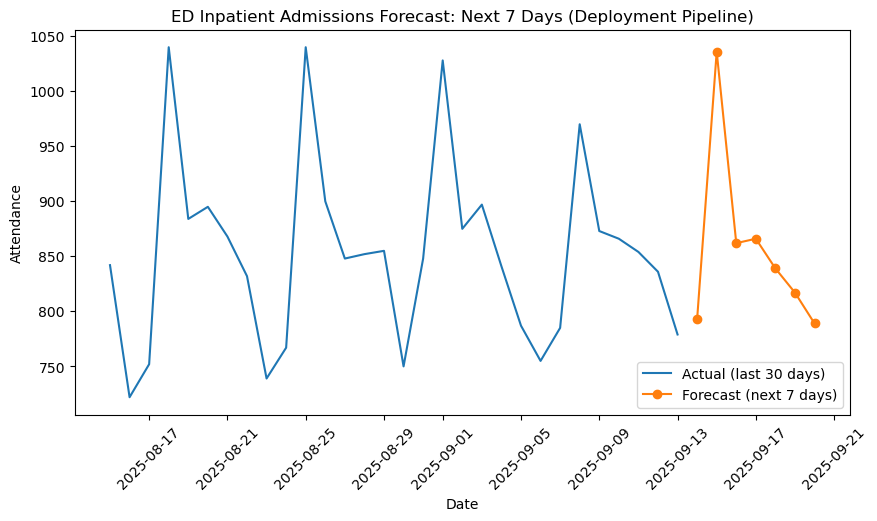

In [78]:
# Train SARIMAX model with latest data and find the best parameters
print("Finding best model parameters with auto_arima")
auto_model = pm.auto_arima(ts_data,
                           start_p=0,
                           start_q=0,
                           max_p=3,
                           max_q=3,
                           seasonal=True,
                           m=7,
                           start_P=0,
                           start_Q=0,
                           max_P=2,
                           max_Q=2,
                           trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)
best_order = auto_model.order
best_seasonal_order = auto_model.seasonal_order
print(f"\nThe Best Order Parameters are: {best_order}")
print(f"The Best Seasonal Order Parameters are: {best_seasonal_order}")
print("\nBest parameters completed. Tuning SARIMAX model with exogenous variables")

# Tuning SARIMAX Model with exogenous vairables
tuned_exog_model = SARIMAX(
    ts_data,
    order=best_order,
    seasonal_order=best_seasonal_order,
    exog=exog
)
tuned_exog_results = tuned_exog_model.fit(disp=False, maxiter=300)

# (Optional) Save the retrained model
model_dir = "../models"
os.makedirs(model_dir, exist_ok=True)
joblib_path = os.path.join(model_dir, "sarimax_tuned_exog_model.joblib")
joblib.dump(tuned_exog_results, joblib_path)
print(f"\nSaving model at: {model_dir}")

# Forecast for future dates (Modifiy this for next week dates)
future_dates = pd.date_range(start="2025-09-14", periods=7, freq='D')
future_exog_df = pd.DataFrame({'Date': future_dates})
future_exog_df = add_exogenous_features(
    future_exog_df,
    public_holidays_path="../data/holidays/singapore_public_holidays_2023_2025.csv",
    school_holidays_path="../data/holidays/singapore_school_holidays_2023_2025.csv"
)
future_exog = future_exog_df[exog_vars].set_index(future_dates)

# Make sure the steps in future_forecasr is the same values as the periods in future_dates
print(f"Forecasing futures dates from: {future_dates} in {len(future_dates)} days")
future_forecast = tuned_exog_results.get_forecast(steps=7, exog=future_exog)
future_predicted = future_forecast.predicted_mean.round().astype(int)

print("\nNext 7 days forecasted admissions (tuned model with exogenous variables):")
print(future_predicted)
print(f"Total forecasted admissions for next {len(future_dates)} days: {future_predicted.sum():.0f}")

# Plot out the Forecast
plot_actual_vs_forecast(ts_data, future_predicted, "ED Inpatient Admissions Forecast: Next 7 Days (Deployment Pipeline)")

In [79]:
### Save forecast to CSV
future_predicted.to_csv("../results/ed_forecast_next7days.csv", header=["Date"])